In [1]:
import CSV
import TypedTables: Table, columnnames
import Printf: @sprintf # For converting numbers to strings
using Revise # Allow code updating

Load the isochrone table using `CSV.read` into a `TypedTables.Table` structure. This contains an isochrone table from PARSEC that has 26 steps in [M/H] and 71 steps in `logAge=log10(age [yr])` for a total of 1846 unique isochrones.

In [2]:
table = CSV.read("../../../../Work/Resources/isochrones/parsec/jwst/nircam_nov22/table.dat", Table; comment="#", delim=' ', ignorerepeated=true, 
    header=["Zini", "MH", "logAge", "Mini", "int_IMF", "Mass", "logL", "logTe", "logg", "label", "McoreTP", "C_O", "period0", "period1", "period2", 
        "period3", "period4", "pmode", "Mloss", "tau1m", "X",  "Y", "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", "mbolmag",  "F070W",  "F090W",  "F115W",  
        "F150W",  "F200W",  "F277W",  "F356W",  "F444W",  "F150W2",  "F322W2",  "F140M",  "F162M",  "F182M",  "F210M",  "F250M",  "F300M",  "F335M",  
        "F360M",  "F410M",  "F430M",  "F460M",  "F480M"])

Table with 50 columns and 709192 rows:
      Zini       MH        logAge  Mini      int_IMF  Mass   logL    logTe   ⋯
    ┌─────────────────────────────────────────────────────────────────────────
 1  │ 2.4652e-5  -2.19174  6.6     0.1       1.17111  0.1    -1.436  3.5769  ⋯
 2  │ 2.4652e-5  -2.19174  6.6     0.105145  1.2127   0.105  -1.411  3.5791  ⋯
 3  │ 2.4652e-5  -2.19174  6.6     0.109821  1.24828  0.109  -1.387  3.5809  ⋯
 4  │ 2.4652e-5  -2.19174  6.6     0.124     1.34512  0.124  -1.321  3.5865  ⋯
 5  │ 2.4652e-5  -2.19174  6.6     0.129464  1.37867  0.129  -1.298  3.5885  ⋯
 6  │ 2.4652e-5  -2.19174  6.6     0.140418  1.4407   0.14   -1.252  3.5923  ⋯
 7  │ 2.4652e-5  -2.19174  6.6     0.149107  1.4856   0.149  -1.219  3.595   ⋯
 8  │ 2.4652e-5  -2.19174  6.6     0.183261  1.63379  0.182  -1.1    3.6048  ⋯
 9  │ 2.4652e-5  -2.19174  6.6     0.197245  1.68445  0.196  -1.057  3.6085  ⋯
 10 │ 2.4652e-5  -2.19174  6.6     0.207292  1.71805  0.206  -1.029  3.6111  ⋯
 11 │ 2.4652e

Check the available columns in the table

In [3]:
columnnames(table)

(:Zini, :MH, :logAge, :Mini, :int_IMF, :Mass, :logL, :logTe, :logg, :label, :McoreTP, :C_O, :period0, :period1, :period2, :period3, :period4, :pmode, :Mloss, :tau1m, :X, :Y, :Xc, :Xn, :Xo, :Cexcess, :Z, :mbolmag, :F070W, :F090W, :F115W, :F150W, :F200W, :F277W, :F356W, :F444W, :F150W2, :F322W2, :F140M, :F162M, :F182M, :F210M, :F250M, :F300M, :F335M, :F360M, :F410M, :F430M, :F460M, :F480M)

In [4]:
unique(table.MH) # These are metallicities, [M/H]

26-element Vector{Float64}:
 -2.19174
 -2.1
 -2.0
 -1.9
 -1.8
 -1.7
 -1.6
 -1.5
 -1.4
 -1.3
 -1.2
 -1.1
 -1.0
 -0.9
 -0.8
 -0.7
 -0.6
 -0.5
 -0.4
 -0.3
 -0.2
 -0.1
  0.0
  0.1
  0.2
  0.3

In [5]:
unique(table.logAge) # These are `log10(age)`, where the age is in years.

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001

## Observational Model 

We'll construct a model Hess diagram from the populations in this isochrone table. First we need to set up our observational models for photometric error and incompleteness. You would typically measure these from artificial star tests but we'll make up some models here using functions built into StarFormationHistories.jl.

In [6]:
import StarFormationHistories: Martin2016_complete, exp_photerr

In [7]:
distmod = 25.0 # Distance modulus 
F090W_complete(m) = Martin2016_complete(m,1.0,28.5,0.7)
F150W_complete(m) = Martin2016_complete(m,1.0,27.5,0.7)
F090W_error(m) = min( exp_photerr(m, 1.03, 15.0, 36.0, 0.02), 0.4 )
F150W_error(m) = min( exp_photerr(m, 1.03, 15.0, 35.0, 0.02), 0.4 );

We'll make a few plots showing the adopted models. Below we set up PyPlot.jl (a wrapper for Python's matplotlib package).

In [8]:
import PyPlot as plt
import PyPlot: @L_str # For LatexStrings
import PyCall: @pyimport
plt.rc("text", usetex=true)
plt.rc("font", family="serif", serif=["Computer Modern"], size=14)
plt.rc("figure", figsize=(5,5))
plt.rc("patch", linewidth=1, edgecolor="k", force_edgecolor=true) 

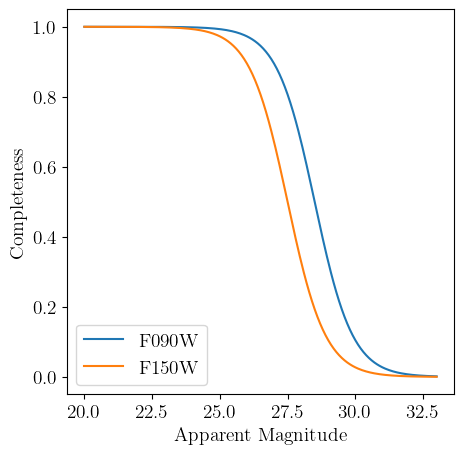

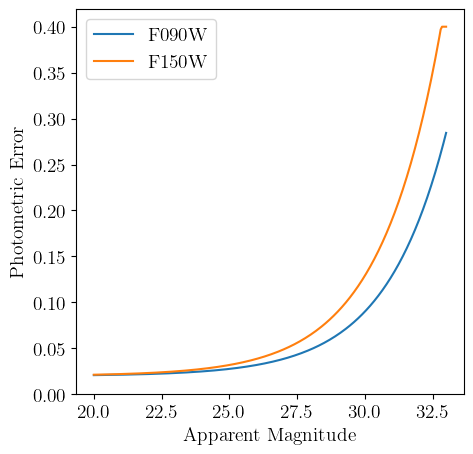

(0.0, 0.41895850114873723)

In [9]:
plotmags=20.0:0.05:33.0

fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_complete.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_complete.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Completeness")
ax1.legend(loc="lower left")

plotmags=20.0:0.05:33.0
fig,ax1=plt.subplots()
ax1.plot(plotmags,F090W_error.(plotmags),label="F090W")
ax1.plot(plotmags,F150W_error.(plotmags),label="F150W")
ax1.set_xlabel("Apparent Magnitude")
ax1.set_ylabel("Photometric Error")
ax1.legend(loc="upper left")
ax1.set_ylim([0.0,ax1.get_ylim()[2]])

We put a maximum on the magnitude error in the model because most of the time one would place a cut on the photometric catalog in either signal to noise (e.g., SNR>5) or magnitude error (e.g., error < 0.4). From a practical perspective, if we allow the photometric error model to grow too large, it will hurt the efficiency of `partial_cmd_smooth` for template creation later.

## Template Construction

We may now define our mock star formation history. We will use `partial_cmd_smooth` to construct the templates for a Hess diagram model with F150W on the y-axis and F090W-F150W on the x-axis, with an initial mass function model from InitialMassFunctions.jl. We'll construct all 1846 templates, one for every isochrone in our table, but this may not always be necessary.

In [10]:
import StarFormationHistories: partial_cmd_smooth
import InitialMassFunctions: Kroupa2001

In [11]:
# Some additional setup
imf = Kroupa2001(0.08, 100.0) # Initial mass function model
unique_logAge = unique(table.logAge)
unique_MH = unique(table.MH)
template_norm = 1e3 # The stellar mass of the populations in each template
edges = (range(-0.65, 1.75, length=100), range(distmod-7.0, distmod+3.0, length=100)) # The bin edges for the Hess diagrams (17,28)

(-0.65:0.024242424242424242:1.75, 18.0:0.10101010101010101:28.0)

In [12]:
# Constructing the templates
templates = Vector{Matrix{Float64}}(undef,0)
template_logAge = Vector{Float64}(undef,0)
template_MH = Vector{Float64}(undef,0)
# We don't strictly need to save the initial masses (m_ini) or the isochrone magnitudes (iso_mags), 
# but we'll use them later in this example so we'll save them now. 
template_mini = Vector{Vector{Float64}}(undef,0)
template_isomags = Vector{Vector{Vector{Float64}}}(undef,0)
for logage in unique_logAge 
    for mh in unique_MH
        # Combination of a logage and an MH defines a unique isochrone.
        # Pick out all entries in `table` that match this combination; these will be row indices
        # into the table of the stars in this specific isochrone.
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last entry in the isochrone because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1] # These are the initial masses of the stars in the isochrone, in solar masses.
        push!(template_mini, m_ini)
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone.
        push!(template_isomags, iso_mags)
        # Create template and push
        push!(templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(template_logAge, logage)
        push!(template_MH, mh)
    end
end

In [13]:
# Sort the template_logAge and template_MH so we have a guarantee for later
permidx = sortperm(template_logAge)
template_logAge = template_logAge[permidx]
template_MH = template_MH[permidx]
templates = templates[permidx]

1846-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.

We'll plot a few templates for reference.

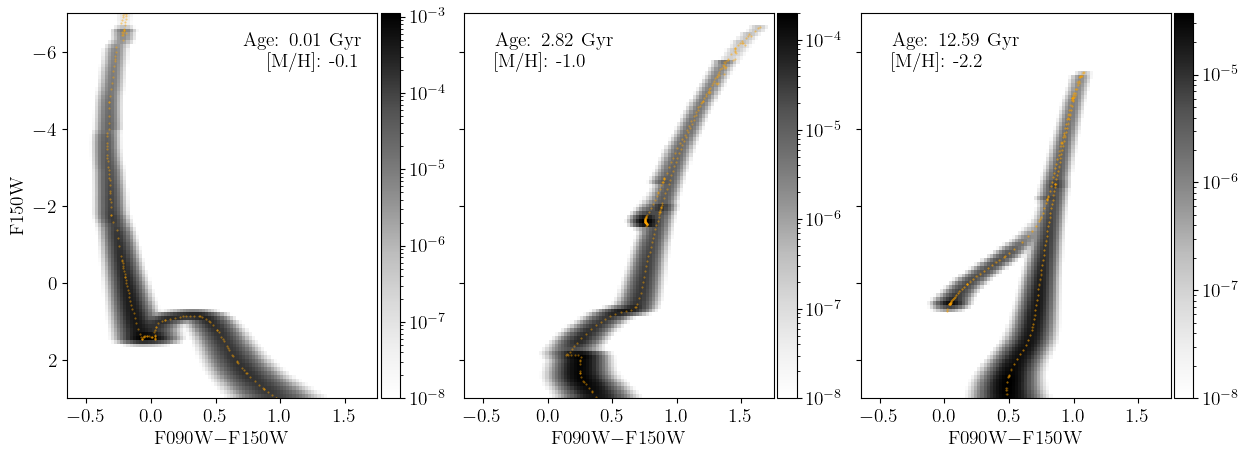

In [17]:
# When displaying the templates we will divide them by template_norm so that that units of the templates are [N / M_sun], or expected number of stars per bin per solar mass of stars formed.
# Plotting in absolute magnitude here rather than apparent on y-axis
display_templates = (100,1495,1821) #(100,1500,1800)
fig,axs=plt.subplots(1,3,sharey=true,sharex=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.075)

im1 = axs[1].imshow(permutedims(templates[display_templates[1]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
im2 = axs[2].imshow(permutedims(templates[display_templates[2]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
im3 = axs[3].imshow(permutedims(templates[display_templates[3]]) ./ template_norm, origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2] .- distmod)...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=1e-8), rasterized=true) 
# im1.set_clim( [0.5, im1.get_clim()[2]] )
for ax in axs
    ax.set_xlabel(L"F090W$-$F150W")
end
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2])).-distmod) 
axs[1].set_xlim(extrema(edges[1]))
# Label the templates with their ages and metallicities
axs[1].text(0.95,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[1]])/1e9 template_MH[display_templates[1]]), transform=axs[1].transAxes,ha="right",va="top")
axs[2].text(0.1,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[2]])/1e9 template_MH[display_templates[2]]), transform=axs[2].transAxes,ha="left",va="top")
axs[3].text(0.1,0.95,(@sprintf "Age: %.2f Gyr \n [M/H]: %.1f" exp10(template_logAge[display_templates[3]])/1e9 template_MH[display_templates[3]]), transform=axs[3].transAxes,ha="left",va="top")
fig.colorbar(im1, ax=axs[1], pad=0.01)
fig.colorbar(im2, ax=axs[2], pad=0.01)
fig.colorbar(im3, ax=axs[3], pad=0.01)

# Optionally, plot photometric error bars along the left. Errors are small in this model so they don't show very well.
plot_errors::Bool = false
if plot_errors
    # Set up points to show the photometric errors
    error_points = minimum(edges[2])+1.0:0.5:maximum(edges[2])-0.5
    error_points_x = repeat([minimum(edges[1])+0.15], length(error_points))
    
    # Plot the photometric error points
    for ax in axs
        ax.errorbar(error_points_x, error_points, yerr=F150W_error.(error_points), xerr=sqrt.(F090W_error.(error_points_x .+ error_points).^2 .+ F150W_error.(error_points).^2), ls="") # , fmt='', ecolor=None, elinewidth=None, capsize=None
    end
end

# Optionally, overplot the isochrones themselves for comparison
plot_isochrones::Bool = true
if plot_isochrones
    alphas = (0.5,0.5,0.2)
    for (i,t_i) in enumerate(display_templates)
        local good = findall( (table.MH .== template_MH[t_i]) .& (table.logAge .== template_logAge[t_i]) )
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]] # These are the absolute magnitudes we want from the isochrone. 
        axs[i].scatter(iso_mags[1] .- iso_mags[2], iso_mags[2],marker=".", c="orange", s=1, alpha=alphas[i])
    end
end
# plt.savefig("template_example.pdf",bbox_inches="tight")

## Building a Model Hess Diagram

We may now use `construct_x0_mdf` and `calculate_coeffs_mdf` to create a mock star formation history with constant star formation rate and a reasonable metallicity evolution for a dwarf galaxy. 

In [18]:
import StarFormationHistories: construct_x0_mdf, calculate_coeffs_mdf

In [19]:
# Set overall stellar mass of complex population and metallicity evolution variables
stellar_mass = 1e7
α, β, σ = -0.1, -0.5, 0.1
# max_logage sets the highest bin edge for the template_logAge
# if template_logage was [6.6,6.7,6.8], I would set max_logAge=6.9, 
# representing the rightmost bin edge. In our case, our oldest template
# is quite old, so we'll make it either the Hubble time or the maximum of 
# template_logAge plus the isochrone logage grid spacing, which is 0.05.
max_logAge = min(log10(13.7e9), maximum(template_logAge) + 0.05)
# We have to divide `stellar_mass` by `template_norm` here because `template_norm` is the total amount of stellar mass in each template, since we passed `normalize_value=template_norm` 
# when constructing the templates with `partial_cmd_smooth`. As such, when computing coefficients, we need to normalize out the adopted `normalize_value` for the templates.
x0_mdf = construct_x0_mdf(template_logAge, max_logAge; normalize_value=stellar_mass / template_norm)

71-element Vector{Float64}:
   0.35467548527633025
   0.39795243976854044
   0.44650998135479286
   0.5009924391101028
   0.5621227621472873
   0.6307121127124622
   0.707670629815149
   0.7940195062200915
   0.8909045390546746
   0.9996113338407291
   1.121582363698718
   1.2584361100895582
   1.4119885390804594
   ⋮
 316.1121376527193
 354.6836520752058
 397.96160306759907
 446.5202627454224
 501.0039750201435
 562.1357056512201
 630.7266355627485
 707.686924721193
 794.0377894053546
 890.9250531259761
 999.6343510072664
 810.787431184313

The above coefficients are the amount of stellar mass formed in each age bin of `unique(template_logAge)`. To construct the complex Hess diagram, we need individual per-template weights, which we can get with `calculate_coeffs_mdf`.

In [20]:
x0 = calculate_coeffs_mdf(x0_mdf, template_logAge, template_MH, α, β, σ)

1846-element Vector{Float64}:
 1.0784236208247173e-63
 3.8788896941154133e-57
 2.0822982855960979e-50
 4.112292253869524e-44
 2.9876555097309864e-38
 7.985140944691229e-33
 7.8512746626311125e-28
 2.839901474068785e-23
 3.778956508846406e-19
 1.8498905440815837e-15
 3.3313916223059323e-12
 2.2070433532521178e-9
 5.379000159317994e-7
 ⋮
 3.476102941613665e-18
 1.4429767888751947e-22
 2.2035939910618868e-27
 1.2379677516088968e-32
 2.5585423032937074e-38
 1.945276724845615e-44
 5.44096205362989e-51
 5.598549490949847e-58
 2.1192435227357725e-65
 2.95115299717703e-73
 1.511847911213934e-81
 2.849246354391387e-90

Let's plot the cumulative SFH and mean [M/H] of our model population.

In [21]:
import StarFormationHistories: calculate_cum_sfr
unique_template_logAge, cum_sfr_arr, sfr_arr, mean_mh_arr = calculate_cum_sfr(x0, template_logAge, max_logAge, template_MH; normalize_value=template_norm)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999994, 0.9999645324514719, 0.9999247372074951, 0.9998800862093595, 0.9998299869654486, 0.9997737746892339, 0.9997107034779626, 0.9996399364149813, 0.9995605344643593, 0.9994714440104538  …  0.6741419731491236, 0.6343458128423638, 0.5896937865678216, 0.5395933890658072, 0.4833798185006851, 0.4203071549444103, 0.349538462472291, 0.2701346835317555, 0.18104217821915794, 0.08107874311843127], [0.0007301391778410211, 0.0007301391778410209, 0.0007301391778410211, 0.0007301391778410213, 0.0007301391778410211, 0.0007301391778410209, 0.0007301391778410213, 0.000730139177841021, 0.0007301391778410212, 0.0007301391778410209  …  0.0007301391778410209, 0.000730139177841021, 0.000730139177841021, 0.0007301391778410212, 0.0007301391778410212, 0.000730139177841021, 0.0007301391778410213, 0.0007301391778410211, 0.0007301391778410212, 0.0

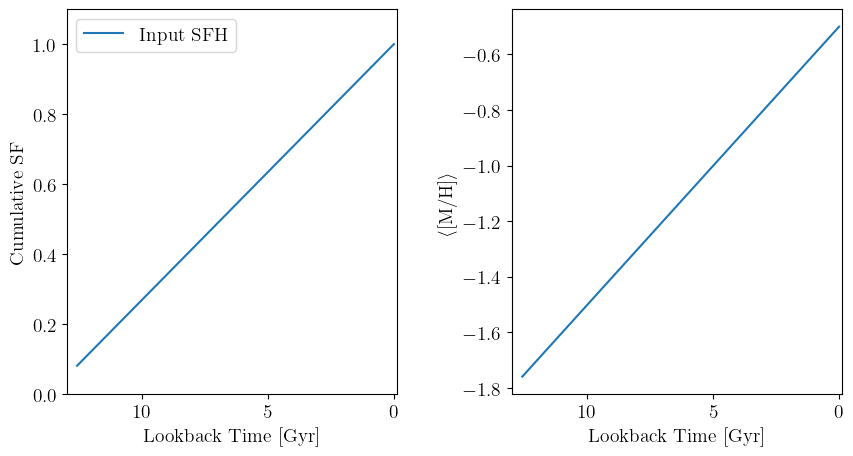

PyObject Text(457.3650849792141, 0.5, '$\\langle$[M/H]$\\rangle$')

In [22]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

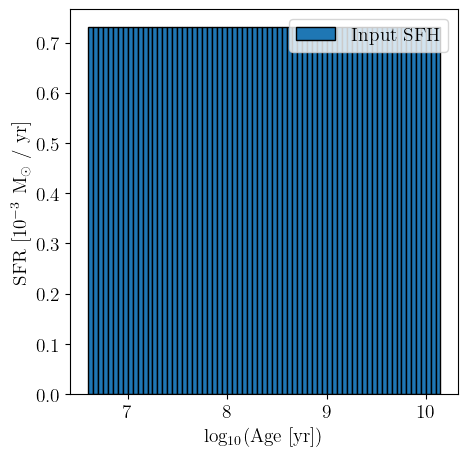

PyObject <matplotlib.legend.Legend object at 0x7f338eb5e650>

In [23]:
fig,ax1 = plt.subplots()
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.set_xlabel(L"log$_{10}$(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Now let's make a model Hess diagram with this SFH. We can simply write `composite = sum( coeffs .* models)` if we want, but we also provide the `composite!` function that is more efficient.

In [24]:
model1 = sum( x0 .* templates)

99×99 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 3.56456e-74  2.21451e-73  6.60495e-73     0.0          0.0
 1.02115e-12  4.27201e-10  1.77872e-9      1.73203e-56  0.0
 3.38063e-8   7.15688e-8   1.26605e-7      1.23755e-31  5.04781e-50
 1.10255e-6   2.12772e-6   3.50149e-6   …  5.77254e-23  3.22837e-31
 1.84446e-5   3.25563e-5   5.03035e-5      2.04266e-18  1.89995e-23
 0.000159513  0.000258425  0.000377791     2.4645e-15   2.67285e-19
 ⋮                                      ⋱               
 0.0954921    0.127511     0.167095        7.59873e-5   5.84647e-5
 0.122        0.162952     0.206031      

In [25]:
model2 = similar(model1)
import StarFormationHistories: composite!
composite!(model2, x0, templates)
model2

99×99 Matrix{Float64}:
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 0.0          0.0          0.0          …  0.0          0.0
 0.0          0.0          0.0             0.0          0.0
 3.56456e-74  2.21451e-73  6.60495e-73     0.0          0.0
 1.02115e-12  4.27201e-10  1.77872e-9      1.73203e-56  0.0
 3.38063e-8   7.15688e-8   1.26605e-7      1.23755e-31  5.04781e-50
 1.10255e-6   2.12772e-6   3.50149e-6   …  5.77254e-23  3.22837e-31
 1.84446e-5   3.25563e-5   5.03035e-5      2.04266e-18  1.89995e-23
 0.000159513  0.000258425  0.000377791     2.4645e-15   2.67285e-19
 ⋮                                      ⋱               
 0.0954921    0.127511     0.167095        7.59873e-5   5.84647e-5
 0.122        0.162952     0.206031      

In [26]:
model1 ≈ model2

true

Let's plot the smooth model.

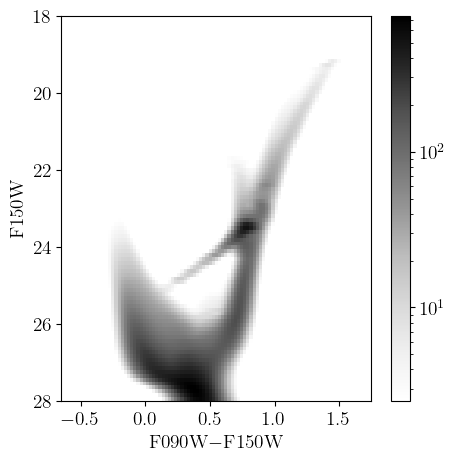

PyObject <matplotlib.colorbar.Colorbar object at 0x7f338ee6f3d0>

In [27]:
fig,ax1=plt.subplots()

im1=ax1.imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
ax1.set_xlabel(L"F090W$-$F150W")
ax1.set_ylabel("F150W")
ax1.set_ylim(reverse(extrema(edges[2]))) 
ax1.set_xlim(extrema(edges[1]))
fig.colorbar(im1)

## Sampling Methods for CMDs and Hess Diagrams

The templates are constructed such that the 2D histogram pixel values give the expected number of stars in that bin for a population with total stellar mass `normalize_value` (in our case we defined the variable `template_norm=1e3` and used that as our `normalize_value` for the templates). As such the pixel values of this complex model also represent expected numbers of stars per bin for our defined SFH. We may, therefore, simply Poisson sample it to obtain a reasonable observational realization of the Hess diagram:

In [28]:
import Distributions: Poisson
import Random: AbstractRNG, default_rng
function poisson_sample!(sample::T, model::S, rng::AbstractRNG=default_rng()) where {T <: AbstractArray{<:Number}, S <: AbstractArray{<:Number}}
    @assert axes(sample) == axes(model)
    for i in eachindex(sample, model)
        sample[i] = rand(rng,Poisson(model[i]))
    end
end
poisson_sample(model::AbstractArray{<:Number}, rng::AbstractRNG=default_rng()) = (sample = similar(model); poisson_sample!(sample, model, rng); return sample)
model3 = poisson_sample(model2)

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

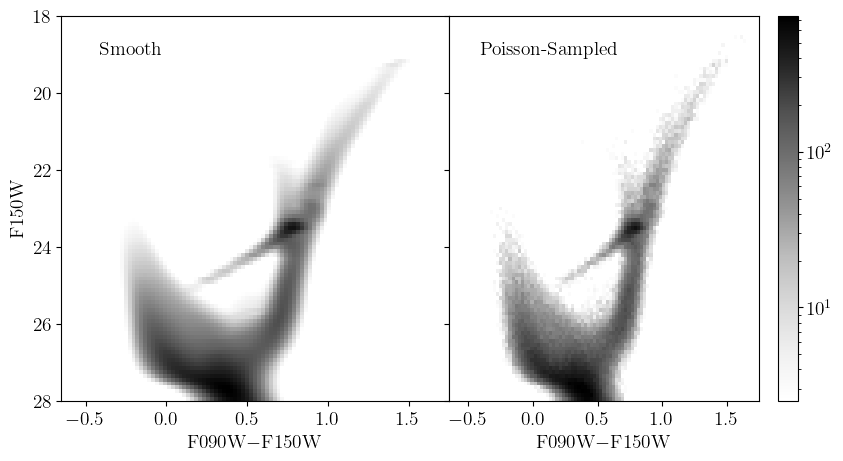

PyObject <matplotlib.colorbar.Colorbar object at 0x7f338d1be5c0>

In [29]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1, ax=axs[2])

To sample the color-magnitude diagram (CMD) directly we could use `generate_stars_mass_composite`,

In [30]:
import StarFormationHistories: generate_stars_mass_composite, NoBinaries
starcat = generate_stars_mass_composite(template_mini, template_isomags, ["F090W", "F150W"], stellar_mass, x0, imf; dist_mod=distmod, binary_model=NoBinaries())

(Vector{StaticArraysCore.SVector{1, Float64}}[[], [[1.59086722380788]], [[0.09595830303171324]], [], [[0.19126106255515218]], [[1.8002861367615028]], [[0.12746848894906365]], [[0.161962552507293]], [[2.4564092816501777]], [[0.11830333311438095]]  …  [], [[0.2789869930736989]], [[0.12027927119580038]], [[0.2731924693722446]], [[0.5481832854470043]], [[0.5875490180145376]], [], [[0.5358778444708383]], [], [[0.22948111245849304]]], Vector{StaticArraysCore.SVector{2, Float64}}[[], [[27.23556905396417, 27.275499750166766]], [[32.46618513537497, 31.313701707197346]], [], [[31.562222939837508, 30.43723733257322]], [[27.21783959792524, 27.299959899481312]], [[32.158272538181166, 30.978450598729875]], [[31.858569692744606, 30.682754055616947]], [[26.734436700348972, 26.87310330095317]], [[32.20814849612162, 31.004392308783224]]  …  [], [[33.71820541198416, 32.526481247560085]], [[36.035003579983545, 34.62557106655769]], [[33.914418564662256, 32.65930728306982]], [[31.74122256267543, 30.58116886

We'll concatenate the per-population samples returned from `generate_stars_mass_composite` into a single `Vector{SVector}`. 

In [31]:
# starcat_mags = reduce(hcat,reduce(vcat,starcat[2])) # For 2D matrix
starcat_mags = reduce(vcat,starcat[2])

14738267-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [27.23556905396417, 27.275499750166766]
 [32.46618513537497, 31.313701707197346]
 [31.562222939837508, 30.43723733257322]
 [27.21783959792524, 27.299959899481312]
 [32.158272538181166, 30.978450598729875]
 [31.858569692744606, 30.682754055616947]
 [26.734436700348972, 26.87310330095317]
 [32.20814849612162, 31.004392308783224]
 [32.37596037065667, 31.162533214561794]
 [29.79871889057167, 28.736977374961214]
 [32.10936053189357, 30.892593778155213]
 [30.768416982891942, 29.589009233502942]
 [32.37548322696357, 31.130567492132258]
 ⋮
 [31.773047268188428, 30.788326834187274]
 [33.32007413568422, 32.23943509894269]
 [35.77358713043924, 34.54017668968512]
 [34.580762398462355, 33.40217614385269]
 [34.97415651766264, 33.76795061851519]
 [33.71820541198416, 32.526481247560085]
 [36.035003579983545, 34.62557106655769]
 [33.914418564662256, 32.65930728306982]
 [31.74122256267543, 30.58116886158348]
 [31.49231575350767, 30.32809418

Now we'll mock observe the "pure" catalog with the same observational models we used to construct the templates using `model_cmd`.

In [32]:
import StarFormationHistories: model_cmd
obs_mags = model_cmd( starcat_mags, [F090W_error, F150W_error], [F090W_complete, F150W_complete] )

212806-element Vector{StaticArraysCore.SVector{2, Float64}}:
 [27.21740846122171, 27.27285756709603]
 [26.91581328717446, 26.352371613001907]
 [25.581760496565007, 25.85816101439104]
 [27.75392439179191, 27.12580011276826]
 [26.40436615504495, 26.308735703807614]
 [26.406137115821256, 26.04672604391947]
 [21.940082111340853, 22.26227063793836]
 [25.19848846662716, 25.37109006275415]
 [22.82512535710603, 23.098079716041322]
 [25.48388807292747, 25.680344289041496]
 [26.26878414501542, 26.456410014445147]
 [28.383428886125586, 27.601882317189297]
 [26.108963325270903, 25.811188589209223]
 ⋮
 [27.13288621746554, 26.437084410846264]
 [27.493157943668596, 26.647368634907796]
 [29.762823506560025, 29.32548107370359]
 [27.498592616620307, 26.847473854937782]
 [24.8240366265096, 24.020528709785804]
 [24.526593612186865, 23.664935231180685]
 [27.667277233303242, 27.18763634797735]
 [28.049778352647948, 27.608982836288185]
 [28.722499966493427, 28.33630702553514]
 [29.623506309614847, 29.1034611

Now we'll compute the Hess diagram with `bin_cmd` and compare with our smooth and Poisson-sampled versions. 

In [33]:
# Concatenate into 2D matrix
obs_mags = reduce(hcat,obs_mags)

2×212806 Matrix{Float64}:
 27.2174  26.9158  25.5818  27.7539  …  28.7225  29.6235  24.7855  28.672
 27.2729  26.3524  25.8582  27.1258     28.3363  29.1035  24.2046  28.3527

In [34]:
import StarFormationHistories: bin_cmd
model4 = bin_cmd(view(obs_mags,1,:) .- view(obs_mags,2,:), view(obs_mags,2,:), edges=edges).weights

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

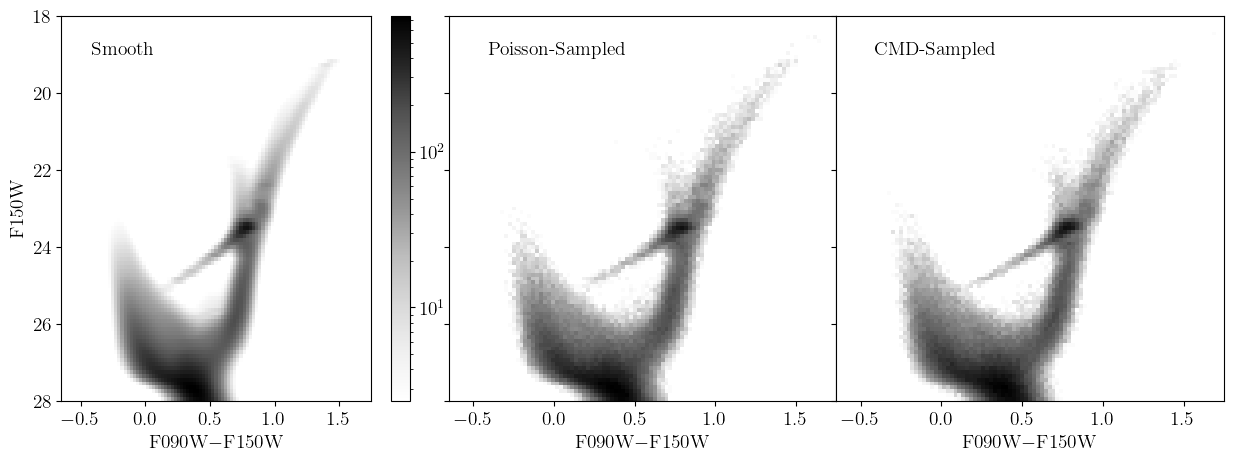

PyObject <matplotlib.colorbar.Colorbar object at 0x7f338c2ff8e0>

In [35]:
fig,axs=plt.subplots(nrows=1,ncols=3,sharex=true,sharey=true,figsize=(15,5))
fig.subplots_adjust(hspace=0.0,wspace=0.0)

im1=axs[1].imshow(permutedims(model2), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5), rasterized=true) 
axs[1].text(0.1,0.9,"Smooth",transform=axs[1].transAxes)
axs[2].imshow(permutedims(model3), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true) 
axs[2].text(0.1,0.9,"Poisson-Sampled",transform=axs[2].transAxes)
axs[3].imshow(permutedims(model4), origin="lower", 
    extent=(extrema(edges[1])..., extrema(edges[2])...), 
    aspect="auto", cmap="Greys", norm=plt.matplotlib.colors.LogNorm(vmin=2.5,vmax=im1.get_clim()[2]), rasterized=true, label="CMD-Sampled") 
axs[3].text(0.1,0.9,"CMD-Sampled",transform=axs[3].transAxes)

axs[1].set_xlabel(L"F090W$-$F150W")
axs[2].set_xlabel(L"F090W$-$F150W")
axs[3].set_xlabel(L"F090W$-$F150W")
axs[1].set_ylabel("F150W")
axs[1].set_ylim(reverse(extrema(edges[2]))) 
axs[1].set_xlim(extrema(edges[1]))
fig.colorbar(im1)

The mock Hess diagram created by Poisson-sampling the smooth model (labelled "Poisson-Sampled") and the Hess diagram created by sampling stars via `generate_stars_mass_composite` and mock observing them with `model_cmd` (labelled "CMD-Sampled") are highly consistent. The Poisson-sampled method is more efficient if a Hess diagram is all that is required, but if you need individual stars (e.g., for forming a star catalog for injection into images) then you should go the CMD-sampled route.

## SFH Fitting: Unconstrained Fitting

We will now explore the methods offered to fit SFHs. We will adopt the Poisson-sampled model Hess diagram above for this purpose.

### Simple Optimization

In [36]:
data = model3

99×99 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

The best way to fit this SFH would be to use `fit_templates_mdf` as it uses the same hierarchical model as we used to generate the SFH (fitting stellar masses per bin in logage, and a mean metallicity relation with Gaussian scatter). We will first show how to use some of the simpler fitting methods that fit per-template stellar masses. These methods are generally most useful when you have a smaller set of templates that you want to use to fit the SFH. For this purpose, we will create a smaller grid of templates centered around a reasonable (but not exactly correct) metallicity evolution; we will accept any isochrone within ± 0.2 dex of this metallicity evolution guess.

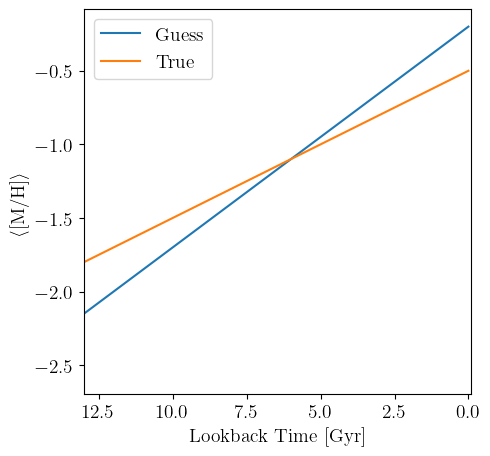

PyObject <matplotlib.legend.Legend object at 0x7f338c28ffd0>

In [37]:
new_α, new_β, new_σ = -0.15, -0.2, 0.2
met_func(logAge) = exp10(logAge) * new_α / 1e9 + new_β
met_func_true(logAge) = exp10(logAge) * α / 1e9 + β
laxplot = 6.6:0.01:10.2
fig,ax1=plt.subplots()
ax1.plot(exp10.(laxplot)./1e9, met_func.(laxplot),label="Guess")
ax1.plot(exp10.(laxplot)./1e9, met_func_true.(laxplot),label="True")
ax1.set_xlim([13.0,-0.1])
ax1.set_xlabel("Lookback Time [Gyr]")
ax1.set_ylabel(L"$\langle$[M/H]$\rangle$")
ax1.legend(loc="upper left")

Now create the limited template set.

In [38]:
free_templates = Vector{Matrix{Float64}}(undef,0)
free_template_logAge = Vector{Float64}(undef,0)
free_template_MH = Vector{Float64}(undef,0)
for logage in unique_logAge
    mean_met = met_func(logage)
    for mh in unique_MH
        # If the current mh is more than `new_σ` dex away from mean, skip template
        abs(mh - mean_met) > new_σ && continue
        local good = findall( (table.MH .== mh) .& (table.logAge .== logage) )
        # Chop off the last star because its the 30 mag weird thing that parsec does.
        local m_ini = table.Mini[good][begin:end-1]
        local iso_mags = [table.F090W[good][begin:end-1], table.F150W[good][begin:end-1]]
        push!(free_templates, partial_cmd_smooth( m_ini, iso_mags, [F090W_error, F150W_error], 2, [1,2], imf, [F090W_complete, F150W_complete]; 
                dmod=distmod, normalize_value=template_norm, edges=edges).weights )
        push!(free_template_logAge, logage)
        push!(free_template_MH, mh)
    end
end

In [39]:
# `templates` has 1846 entries, free_templates has ~10% of that.
length(free_templates)

284

Let's start off by just obtaining the maximum likelihood estimate (MLE) via `fit_templates_lbfgsb`. We'll construct the initial guess vector `x0` with `construct_x0`.

In [40]:
import StarFormationHistories: fit_templates_lbfgsb, construct_x0
lbfgsb_result = fit_templates_lbfgsb(free_templates, data; x0=construct_x0(free_template_logAge, max_logAge; normalize_value=template_norm))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          284     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  284   4779   4800   5092     0   213   9.476D-06   4.586D+03

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 Total User time 3.223E+01 seconds.



(4586.493182728604, [2.0867351912666803, 0.0, 0.0, 1.4584290042137114, 0.0, 0.0, 0.0, 0.6475164971378069, 1.430026609458396, 0.0  …  186.6623974117045, 642.7695192240226, 244.05899100218278, 222.70774632188792, 192.55792028700603, 448.7960288833097, 182.03366019386974, 0.0, 46.890670358018305, 140.0131075320423])

In [41]:
free_coeffs = lbfgsb_result[2] .* template_norm
unique_free_template_logAge, free_cum_sfr_arr, free_sfr_arr, free_mean_mh_arr = calculate_cum_sfr(free_coeffs, free_template_logAge, max_logAge, free_template_MH)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [1.0, 0.9996458416136975, 0.9995811553579742, 0.999438297118285, 0.999438297118285, 0.999438297118285, 0.999438297118285, 0.999438297118285, 0.999438297118285, 0.999438297118285  …  0.69074714752167, 0.6818227489394357, 0.5617784850223121, 0.5499494002224312, 0.5072195520733801, 0.482645173002242, 0.3783205696994241, 0.24590662650721912, 0.1475566413940811, 0.036856484076239905], [0.007298117232384379, 0.0011880242853484597, 0.002338398908245433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005037222212560456  …  0.00016390124923326208, 0.00196491929868247, 0.00017256568921804625, 0.0005555647144544442, 0.0002847645072694851, 0.0010774324393382332, 0.001218812848731483, 0.0008068217619759965, 0.0008093782753367564, 0.00033223958260415786], [-0.27658436192549174, -0.1, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4  …  -0.7718963571745143, -1.0510

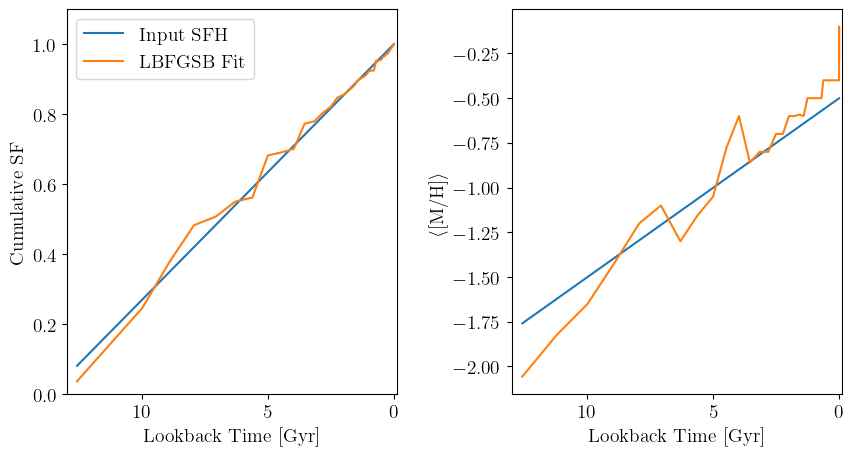

PyObject Text(447.8810729977773, 0.5, '$\\langle$[M/H]$\\rangle$')

In [42]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,5))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, free_cum_sfr_arr, label="LBFGSB Fit" )

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="LBFGSB Fit" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")

We can also use `fit_templates`, which uses BFGS to build a dense estimate of the inverse Hessian. This function is slower than `fit_templates_lbfgsb` above, but allows for estimation of random uncertainties.

In [43]:
import LinearAlgebra: BLAS
BLAS.set_num_threads(1) # BFGS uses BLAS operations, but they are relatively small so it's actually more efficient to run BLAS single-threaded.
import StarFormationHistories: fit_templates
bfgs_result = fit_templates(free_templates, data; x0=construct_x0(free_template_logAge, max_logAge; normalize_value=template_norm))

(map = StarFormationHistories.LogTransformFTResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([0.3796391593445797, 0.35612547198794187, 0.3741826155042427, 0.6963729036353871, 0.32585020525993225, 0.27276040663170925, 0.3486081521824407, 0.5030077685217231, 0.34225570167338426, 0.21964241145574098  …  200.4065012824232, 623.762998054823, 240.8434405673296, 224.51340038781805, 196.89500258102754, 456.671173979438, 169.14109662162772, 25.05823823546099, 58.78482847

`bfgs_result.mle` contains information for the maximum likelihood estimate; this is most similar to what is returned by `fit_templates_lbfgsb` but not exactly equal.

In [44]:
bfgs_result.mle.μ .- lbfgsb_result[2]

284-element Vector{Float64}:
  3.9720264670695116e-5
  1.4292883181618266e-129
  3.449802635919014e-209
  6.924856261747436e-7
  9.384569334562293e-63
  5.068877799947162e-233
  1.5355551715683122e-195
 -8.163087264478897e-6
 -2.8747246973770402e-5
  1.533133387764926e-300
  0.0
  0.0
  1.664494318018666e-161
  ⋮
  0.0
 -0.006980568926223896
  0.008122471554798949
 -0.008050850662812081
  0.0007236819577371989
 -0.0014763204522978413
  0.0017994963021976673
  0.005414894779619317
  0.000127025319443419
  3.524848156706137e-188
 -0.0034118468790325096
 -0.0008796124220395996

Of additional note are the uncertainty estimates, available as `bfgs_result.map.σ` and `bfgs_result.mle.σ`. The `bfgs_result.map` result contains the maximum a posteriori result and is often very comparable to the mode of posterior samples obtained via Hamiltonian Monte Carlo (provided by `hmc_sample`) or MCMC (provided by `mcmc_sample`). We don't generally recommend the use of `bfgs_result.mle.σ`, but provide it for completeness.

In [45]:
bfgs_result.map.μ

284-element Vector{Float64}:
   0.3796391593445797
   0.35612547198794187
   0.3741826155042427
   0.6963729036353871
   0.32585020525993225
   0.27276040663170925
   0.3486081521824407
   0.5030077685217231
   0.34225570167338426
   0.21964241145574098
   0.18789071717212277
   0.183163734691051
   0.28456372764412236
   ⋮
   7.724035620909234
 143.26601758849986
 200.4065012824232
 623.762998054823
 240.8434405673296
 224.51340038781805
 196.89500258102754
 456.671173979438
 169.14109662162772
  25.05823823546099
  58.78482847245996
 126.17719587872209

In [46]:
bfgs_result.map.σ

284-element Vector{Float64}:
  0.36444950211645516
  0.34548485925811934
  0.36084165861404904
  0.4797112425096111
  0.3178667710043459
  0.26849445939692795
  0.3347145788445831
  0.3998484661560506
  0.33360388667620716
  0.21767316846124654
  0.186731763289907
  0.18208468393889707
  0.2806629270765237
  ⋮
  7.550397131359837
 52.07508259353635
 61.85416213334585
 65.34359140643336
 32.506153701075874
 31.761549939377172
 35.23319513043109
 50.41421366033598
 69.84651148242423
 23.856770073401236
 40.25563686108742
 35.96540081166277

### Sampling from Inverse Hessian

Another thing we can do is draw samples from the posterior approximating the posterior distribution as Gaussians and the inverse Hessian as its variance-covariance matrix. There are additional notes in the documentation on this approximation, but it often reproduces results from more expensive Monte Carlo sampling methods fairly well. In short, we are approximating the posterior (in the transformed fitting variables `θ = log(coeffs)`) as a multivariate Gaussian in the region of the MAP estimate. For a multivariate Gaussian, the inverse of the Hessian matrix (which the BFGS algorithm from Optim.jl computes for us) is an estimator for the variance-covariance matrix. In concert with the MAP estimate for the parameters, this gives us both the means μ and the variance-covariance matrix Σ needed to define our multivariate Gaussian approximation of the posterior, which we can then sample from using `MvNormal` from Distributions.jl.

In [47]:
import Statistics: mean, median, quantile

hessian_sample = rand(bfgs_result.map, 10000) .* template_norm
# The above is effectively doing
# hessian_dist = Distributions.MvNormal(Optim.minimizer(bfgs_result.map.result),
#                         LinearAlgebra.Hermitian(bfgs_result.map.invH))
# hessian_sample = exp.(rand(hessian_dist, 10000)) .* template_norm

# Calculate the cumulative SFH for each sample
# and find the 1-σ quantile range for both the cumulative SFH and the SFRs
hessian_cum_sfr = Vector{Vector{Float64}}(undef,0)
hessian_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(hessian_sample)
    _, hessian_1, hessian_2, hessian_mh = calculate_cum_sfr(x, free_template_logAge, max_logAge, free_template_MH)
    push!(hessian_cum_sfr, hessian_1)
    push!(hessian_sfr, hessian_2)
end
hessian_cum_sfr = reduce(hcat, hessian_cum_sfr) 
hessian_sfr = reduce(hcat, hessian_sfr) 
# Now calculate quantiles
hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
hessian_cum_med = median.(eachrow(hessian_cum_sfr))
hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_lower = quantile.(eachrow(hessian_sfr), 0.16)
hessian_sfr_med = median.(eachrow(hessian_sfr))
hessian_sfr_upper = quantile.(eachrow(hessian_sfr), 0.84)

71-element Vector{Float64}:
 0.007507958995799678
 0.005723373995071909
 0.0036374160016276334
 0.002985384769808531
 0.0025288105021416788
 0.0023097869367094473
 0.00212175305850724
 0.001815763901134422
 0.0016383700761011533
 0.001666601686282283
 0.0014695791346935989
 0.001202094708272118
 0.0016222184263550024
 ⋮
 0.0017300954462887003
 0.0005796067165547248
 0.0008746346052158051
 0.001626958634254374
 0.0009113661583751497
 0.0008947318148869395
 0.0005591825068990315
 0.0012696075574052726
 0.001308939450630671
 0.00088130260570527
 0.0008750012309642098
 0.000455783468062785

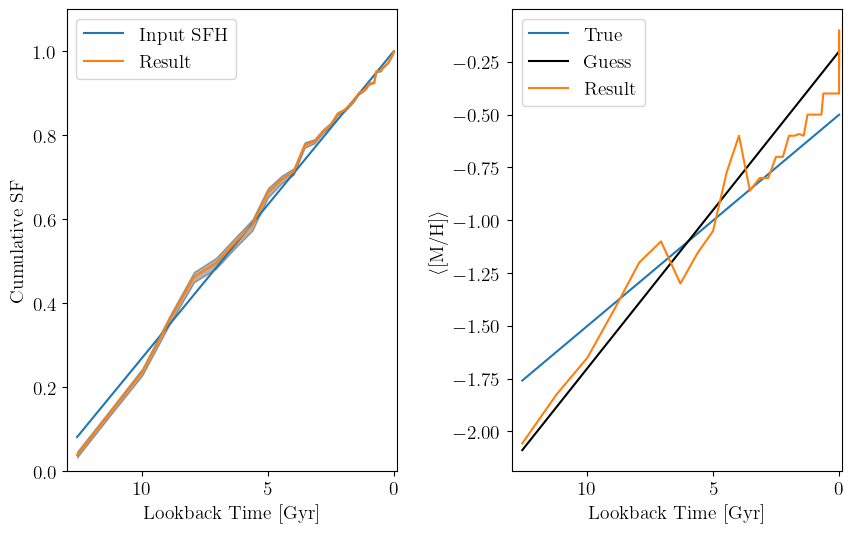

PyObject <matplotlib.legend.Legend object at 0x7f3374fb61a0>

In [48]:
# Now plot cumulative SFH and MH evolution
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
# axs[1].plot( exp10.(unique_free_template_logAge)./1e9, cum_sfr_arr, label="Result" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="Result" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="True" )
axs[2].plot( exp10.(unique_template_logAge)./1e9, met_func.(unique_template_logAge), c="k", label="Guess")
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, free_mean_mh_arr, label="Result" )
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

We can alternatively use the `Measurements.jl` package to estimate the uncertainties on the SFRs assuming that the `bfgs_result.map.σ` are Gaussian and *uncorrelated*. In general we expect some correlation in the star formation rates between age bins, but this approach can be useful for quick diagnostics. 

In [49]:
import Measurements: uncertainty, ±
hessian_sfrerr = uncertainty.(calculate_cum_sfr(bfgs_result.map.μ .± bfgs_result.map.σ,
                                                            free_template_logAge, max_logAge, free_template_MH; normalize_value=template_norm)[3]) .* 1e3

71-element Vector{Float64}:
 1.6111355015917994
 1.223980761901288
 0.7785690277482392
 0.6228215736870608
 0.5371762560684277
 0.4936517853063783
 0.45214449644340904
 0.38448151668750485
 0.3676964629447116
 0.3854019213806302
 0.3525029590437847
 0.2945574530741858
 0.48523968787106936
 ⋮
 0.1457841923483523
 0.11814243353614311
 0.2041835814673481
 0.2642986461033047
 0.2060597640141555
 0.16702703875931127
 0.12275214763904571
 0.12740639446931562
 0.10473477761030422
 0.0854221018179656
 0.055857777083613586
 0.08234668441570038

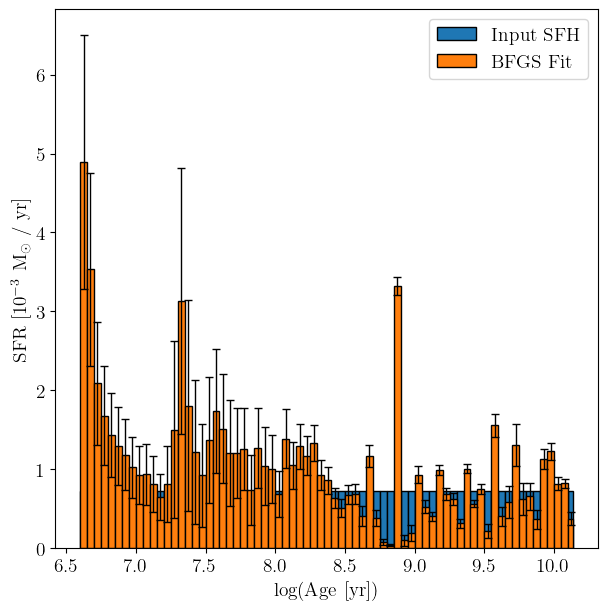

PyObject <matplotlib.legend.Legend object at 0x7f33750233d0>

In [50]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
# ax1.bar(unique_free_template_logAge[begin:end-1], free_sfr_arr[begin:end-1] .* 1e3; width=diff(unique_free_template_logAge), align="edge", yerr = hessian_sfrerr[begin:end-1], capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="LBFGS Fit")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", yerr = hessian_sfrerr, capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

**The random errors here are underestimating the true uncertainty because there is a systematic error in the a priori metallicity evolution model by design.** Analyses using these unconstrained fitting methods which do not enforce a monotonic age-metallicity relation will generally be subject to similar systematics. See the next section for information on the methods we provide for fitting constrained star formation histories with constrained age-metallicity relations, which is our preferred approach.

If we make the same plot with the `hessian_sfr_lower` and `hessian_sfr_upper` vectors, which utilize the samples from the full variance-covariance matrix, we see that the uncertainties look very similar across most of the plot, but are not identical due to the inclusion of covariance between parameters.

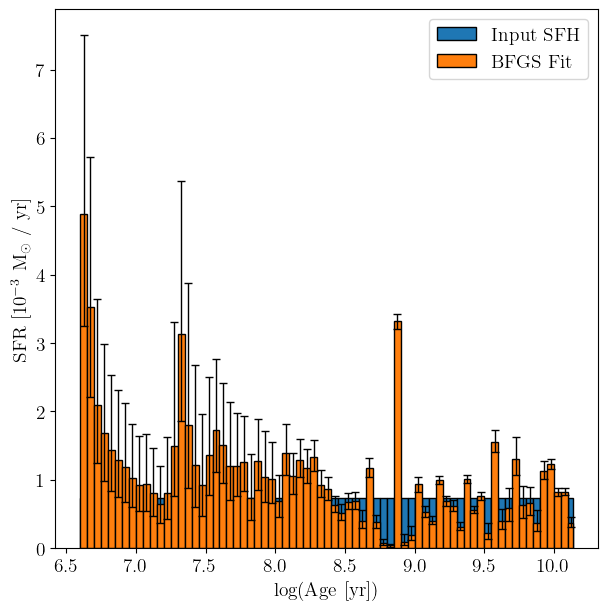

PyObject <matplotlib.legend.Legend object at 0x7f338d2097e0>

In [51]:
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

### Sampling via MCMC
The unconstrained fitting methods are not optimal for MCMC. Since so many of the fitting coefficients are 0, our transition acceptance probabilities are extremely low, giving us fairly poor convergence unless we run very long chains.

In [52]:
import StarFormationHistories: mcmc_sample
import Distributions: MvNormal
import LinearAlgebra: I

nwalkers = 1000
nsteps = 2000
burn_idx = 200
# Walker initial positions sampled from a multivariate normal distribution with means equal to the BFGS MLE
# and identity covariance matrix. The `max` call makes sure none of the cofficients have initial conditions less than 0. 
mcmc_x0 = [max.(0.0, rand(MvNormal(bfgs_result.mle.μ, I))) for i in 1:nwalkers]
mcmc_result = mcmc_sample(free_templates, data, mcmc_x0, nwalkers, nsteps; nthin=5); # nthin=5 to only save every 5 steps

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
emcee, niter=2000000, nwalkers=1000: 100%|█████████████████████████| Time: 0:03:33
  accept_ratio_mean:      0.00405
  accept_ratio_std:       0.00255
  accept_ratio_outliers:  46
  burnin_phase:           false


Note the very low transition acceptance ratio of <1%. If we plot the trace of the chains we can see that they have not reached their stationary distribution even after 2000 steps. MCMC can work well when considering fewer templates, or when fewer of the fitting coefficients are zero. However, this application is better suited to Hamiltonian Monte Carlo. 

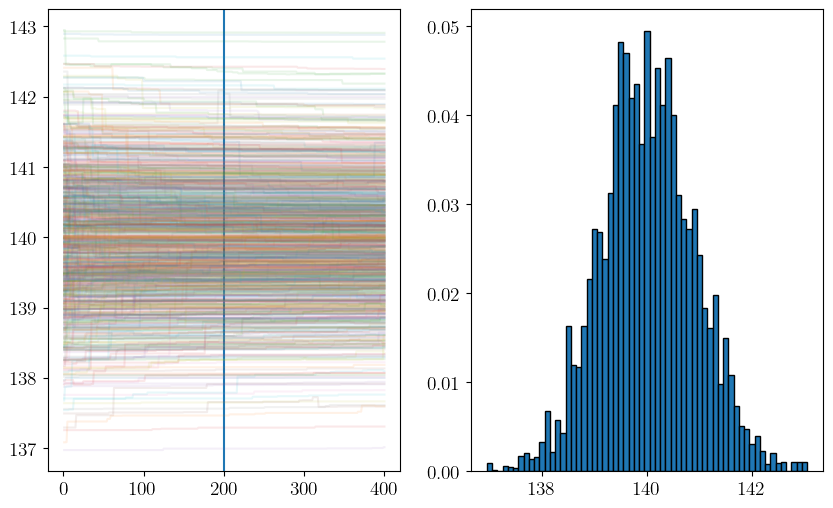

In [53]:
import StatsBase: fit, Histogram, normalize

fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,sharex=false,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.2)

ax0.axvline(burn_idx)
for i in 1:size(mcmc_result,3)
    ax0.plot(first(axes(mcmc_result)), mcmc_result[:,end,i], alpha=0.1, rasterized=true) 
end

ax1_hist = normalize(fit(Histogram, vec(mcmc_result[burn_idx:end,end,:]); nbins=100, closed=:left); mode=:probability) #:pdf, :density, :probability, :none
ax1.bar(first(ax1_hist.edges)[2:end], ax1_hist.weights, width=step(first(ax1_hist.edges)), ec="k"); # fc="k"

### Sampling via Hamiltonian Monte Carlo

Let us now compare to `hmc_sample`, which utilizes the No-U-Turn sampler variant of Hamiltonian Monte Carlo implemented in `DynamicHMC.jl` to sample from the posterior. This is a more rigorous way to obtain posterior samples than using the approximation of `fit_templates` and can be more efficient than `sample_mcmc` for high-dimensional problems or when many of the coefficients are 0. However, we will show that the approximation of `fit_templates` still compares favorably with this more accurate method.

In [54]:
import DynamicHMC
import StarFormationHistories: hmc_sample
mc_result = hmc_sample(free_templates, data, 1000; reporter=DynamicHMC.ProgressMeterReport());

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:22
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:20
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:26
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:39
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:13
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:09
MCMC: 100%|█████████████████████████████████████████████| Time: 0:02:16


We can check the summary statistics to ensure the samples have a high acceptance rate and are converging properly (turning % should be ~100%).

In [55]:
DynamicHMC.Diagnostics.summarize_tree_statistics(mc_result.tree_statistics)

Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.89, 5/25/50/75/95%: 0.6 0.83 0.94 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 99%, 7 => 1%

The parameters optimized by `full_templates` and `hmc_sample` are actually the logarithms of the coefficients, not the coefficients themselves, so we need to transform the samples here.

In [56]:
mc_matrix = exp.(mc_result.posterior_matrix) .* template_norm

284×1000 Matrix{Float64}:
   265.162        594.385      …   1202.53         181.685
  1124.41          64.3758          155.192         14.3456
   206.341        899.817           322.529         79.9627
   718.078        236.044           499.278       1059.15
   474.815        174.719            30.4958       107.599
   158.29         221.015      …    148.154        537.802
    47.0074       190.149           259.881        193.626
   270.325        787.903           394.83         942.636
   281.766        606.779            13.527         42.4907
   580.339         98.4395          134.367        446.868
    27.1256       710.091      …     83.918        276.808
   128.325        300.583           455.992         89.1383
   102.07         675.727           328.68         122.907
     ⋮                         ⋱                 
   925.128       3874.0             928.538      18759.2
 81649.5            1.1063e5          2.67381e5      2.24734e5
     1.98322e5      2.34601e5     

Calculate statistics from the MC samples.

In [57]:
# Calculate the cumulative SFH for each sample in the chain
# and find the 1-σ range
mc_cum_sfr = Vector{Vector{Float64}}(undef,0)
mc_sfr = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mc_matrix)
    _, mc_1, mc_2, mc_mh = calculate_cum_sfr(x, free_template_logAge, max_logAge, free_template_MH)
    push!(mc_cum_sfr, mc_1)
    push!(mc_sfr, mc_2)
end
mc_cum_sfr = reduce(hcat, mc_cum_sfr) # hcat( mc_cum_sfr... )
mc_sfr = reduce(hcat, mc_sfr) # hcat( mc_sfr... )
# Calculate quantiles
mc_cum_lower = quantile.(eachrow(mc_cum_sfr), 0.16)
mc_cum_med = median.(eachrow(mc_cum_sfr))
mc_cum_upper = quantile.(eachrow(mc_cum_sfr), 0.84)
mc_sfr_lower = quantile.(eachrow(mc_sfr), 0.16)
mc_sfr_med = median.(eachrow(mc_sfr))
mc_sfr_upper = quantile.(eachrow(mc_sfr), 0.84)

71-element Vector{Float64}:
 0.005030195801168886
 0.00380864032979254
 0.0021398864025776324
 0.0017976840822211183
 0.0015221154412627296
 0.0014408856943139666
 0.0013208550331426042
 0.001080832150049954
 0.0010647532924559244
 0.0010170552524209435
 0.0008921918612168649
 0.0007638738692500192
 0.0011611363891739915
 ⋮
 0.0016600675591244998
 0.00045283345753528953
 0.0006124488468361516
 0.0015688931993473765
 0.0006968640220535887
 0.0007338091102741378
 0.00041417671754600627
 0.0012083793895873167
 0.0012592802559091864
 0.0008568602250930436
 0.0008690075964893243
 0.00039367394712364

And we'll plot the cumulative SFHs:

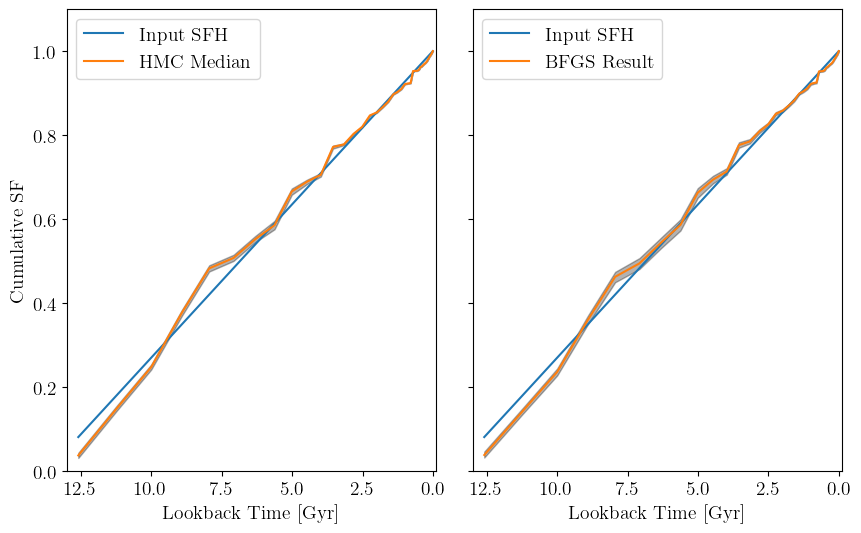

PyObject <matplotlib.legend.Legend object at 0x7f3356b73e80>

In [58]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[1].plot( exp10.(unique_free_template_logAge)./1e9, mc_cum_med, label="HMC Median" )
axs[1].fill_between( exp10.(unique_free_template_logAge)./1e9, mc_cum_lower, mc_cum_upper, alpha=0.3, fc="k") 

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH" )
axs[2].plot( exp10.(unique_free_template_logAge)./1e9, hessian_cum_med, label="BFGS Result" )
axs[2].fill_between( exp10.(unique_free_template_logAge)./1e9, hessian_cum_lower, hessian_cum_upper, alpha=0.3, fc="k") 
axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].legend()

The differences are more obvious in the SFRs,

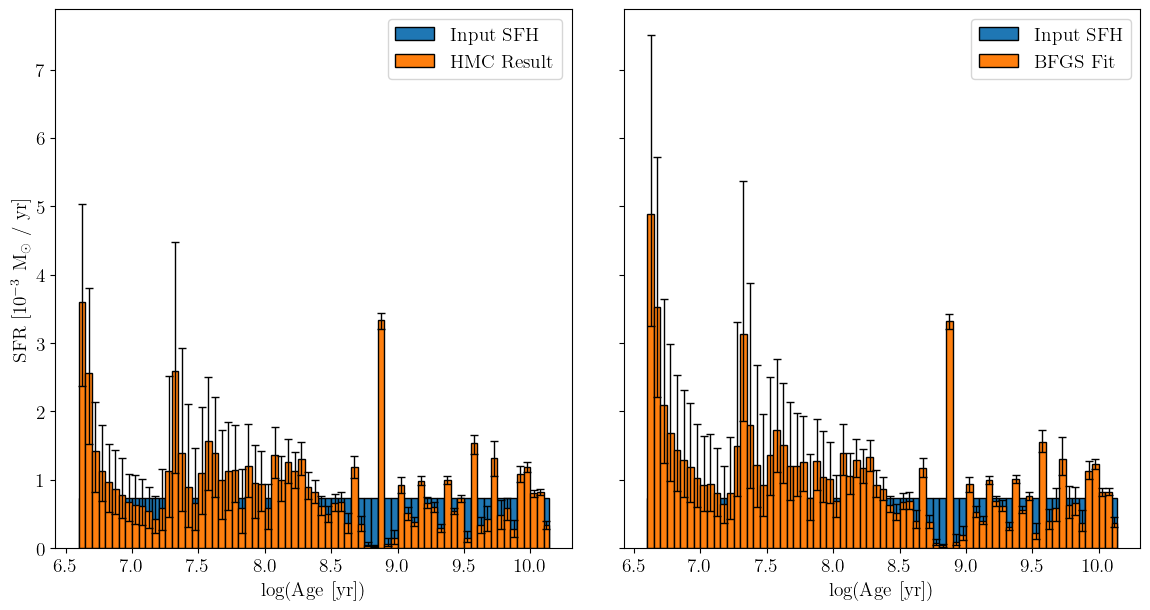

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [59]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mc_sfr_med .- mc_sfr_lower) .* 1e3, 
        (mc_sfr_upper .- mc_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="HMC Result")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

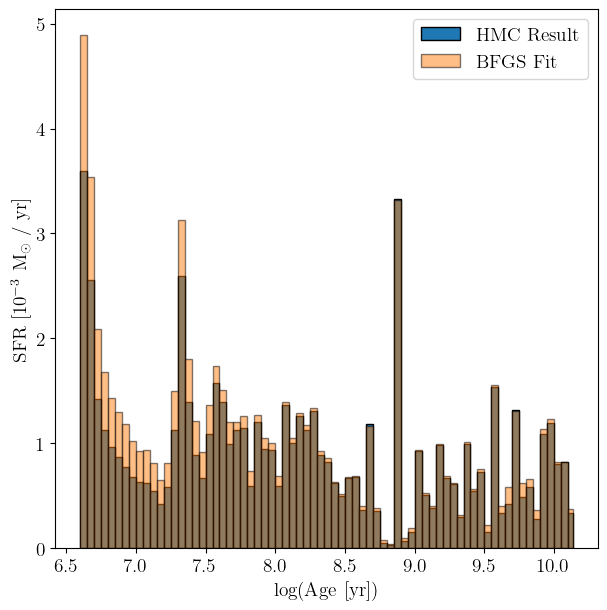

PyObject <matplotlib.legend.Legend object at 0x7f33563f9cf0>

In [60]:
# _, _, tmp_sfr, _ = calculate_cum_sfr(bfgs_result.map.μ .* template_norm, free_template_logAge, free_template_MH)

fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, mc_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="HMC Result")
ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
# ax1.bar(unique_free_template_logAge, tmp_sfr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 

ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

Thus the approximations we made above when deriving the uncertainties from the BFGS results that 
1. the posterior is well-approximated by a multivariate Gaussian in the fitting variables `θ = log(coeffs)` and 
2. the inverse Hessian approximation produced by the BFGS optimization is a good estimate of the variance-covariance matrix of said Gaussian

are not fully correct, but they are good enough in most cases that they can produce very similar posterior samples to the full HMC analysis at a fraction of the computational cost (a few seconds compared to minutes or hours).

### Normalizing Templates to SFR

Because we have normalized the templates to uniform stellar mass above, and not uniform star formation rate, the posterior is slightly biased to favor higher star formation rates at more recent times. This is because our isochrone grid is uniform in `log(age)` and not `age` directly -- we have not accounted for this non-uniform spacing. As such, our priors are uniform in stellar mass per template, and not star formation rate (which is more physical and would be preferred). The maxium likelihood estimate `mle.μ` is insensitive to this effect. We can fix this by normalizing the templates to a fixed star formation rate rather than a fixed stellar mass.

In [61]:
# Compute change in time [yr] between bins of logAge
# diff(vcat(unique_template_logAge,max_logAge))
free_template_δt = diff(vcat(exp10.(unique_free_template_logAge), exp10(max_logAge)))

71-element Vector{Float64}:
 485764.21597466525
 545036.4147630902
 611540.9156307662
 686160.1928984392
 769884.3990394427
 863824.503401449
 969227.0340946363
      1.0874906186625417e6
      1.22018454301963e6
      1.3690695749220327e6
      1.5361213282858916e6
      1.7235564783835877e6
      1.9338621757780854e6
      ⋮
      4.3294778207552767e8
      4.8577540123786354e8
      5.450489648348255e8
      6.115549970428333e8
      6.861759925026665e8
      7.699021264869289e8
      8.638443939246902e8
      9.692493516287975e8
      1.0875156593476849e9
      1.2202126391305141e9
      1.3691010992768898e9
      1.1104560004323616e9

In [62]:
sfr_norm = 1e-3 # Star formation rate in solar masses / yr to normalize templates to
# SFR = stellar mass / dt; sfr_norm = A * template_norm / dt; where A is a multiplicative constant
# since we originally normalized all the templates to contain stellar mass = `template_norm`
# Solve for A = sfr_norm * dt / template_norm
free_sfr_templates = deepcopy(free_templates)
for i in eachindex(free_sfr_templates)
    idx = findfirst(==(free_template_logAge[i]), unique_free_template_logAge)
    A = sfr_norm * free_template_δt[idx] / template_norm
    free_sfr_templates[i] .*= A
end 

In [63]:
# And now fit
sfr_result = fit_templates(free_sfr_templates, data; x0=ones(length(free_sfr_templates)))

(map = StarFormationHistories.LogTransformFTResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([0.7815296952853539, 0.7331241345458422, 0.7702967882541039, 1.4335615517050795, 0.5978503392467855, 0.5004443729048222, 0.6396052522292969, 0.9228883673913915, 0.5596611669343592, 0.3591622497621078  …  0.16423899806148792, 0.51119204784306, 0.17591355392603675, 0.16398599076083062, 0.1438133403046065, 0.33355547831920435, 0.15231679338098536, 0.022565719138495657, 0.05

Since we know that the templates were normalized to uniform star formation rate of `sfr_norm`, the coefficients are now star formation rates and we can plot them directly. 

In [64]:
# Sum the SFRs of all templates with same logAge but different metallicities
sfr_norm_arr = similar(unique_free_template_logAge)
sfr_norm_arr_err = similar(unique_free_template_logAge)
for i in eachindex(unique_free_template_logAge)
    idxs = findall(==(unique_free_template_logAge[i]), free_template_logAge)
    sfr_norm_arr[i] = sum( sfr_result.map.μ[idxs] ) * sfr_norm
    sfr_norm_arr_err[i] = sqrt(sum( sfr_result.map.σ[idxs].^2 )) * sfr_norm
end
sfr_norm_arr .± sfr_norm_arr_err

71-element Vector{Measurements.Measurement{Float64}}:
   0.0037 ± 0.0016
   0.0027 ± 0.0012
  0.00153 ± 0.00078
  0.00123 ± 0.00062
  0.00105 ± 0.00054
  0.00095 ± 0.00049
  0.00086 ± 0.00045
  0.00074 ± 0.00038
  0.00069 ± 0.00037
   0.0007 ± 0.00038
  0.00061 ± 0.00035
  0.00049 ± 0.00029
  0.00067 ± 0.00049
          ⋮
   0.0015 ± 0.00014
  0.00034 ± 0.00012
  0.00048 ± 0.00021
  0.00124 ± 0.00026
  0.00054 ± 0.0002
  0.00056 ± 0.00017
  0.00029 ± 0.00013
  0.00109 ± 0.00012
  0.00119 ± 0.00011
 0.000799 ± 8.8e-5
 0.000817 ± 5.8e-5
 0.000341 ± 8.5e-5

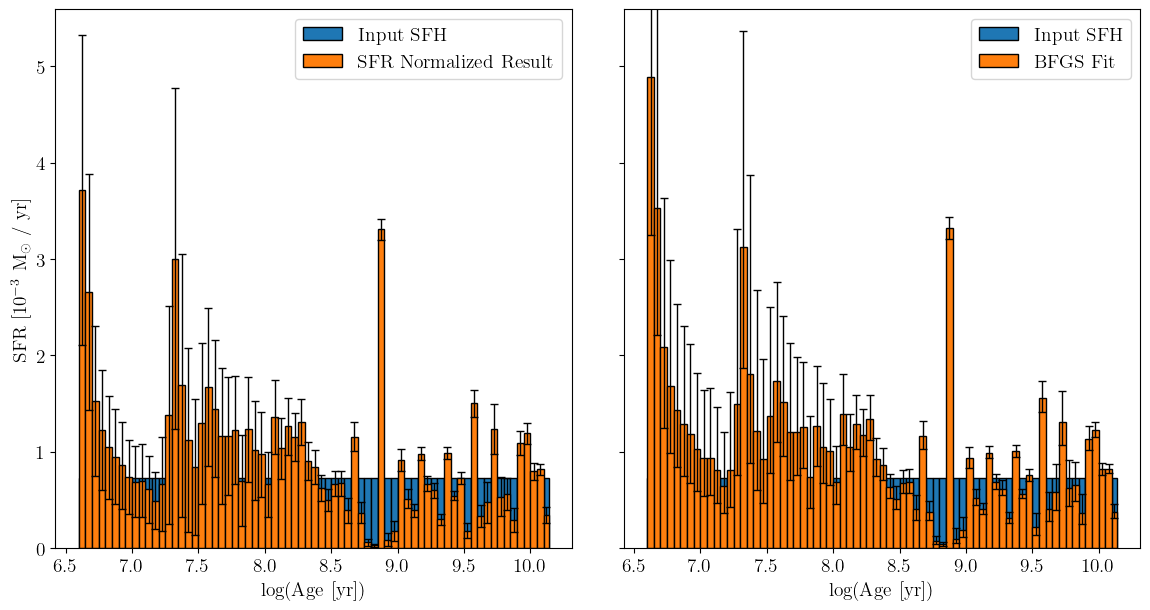

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [65]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = sfr_norm_arr_err .* 1e3, 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

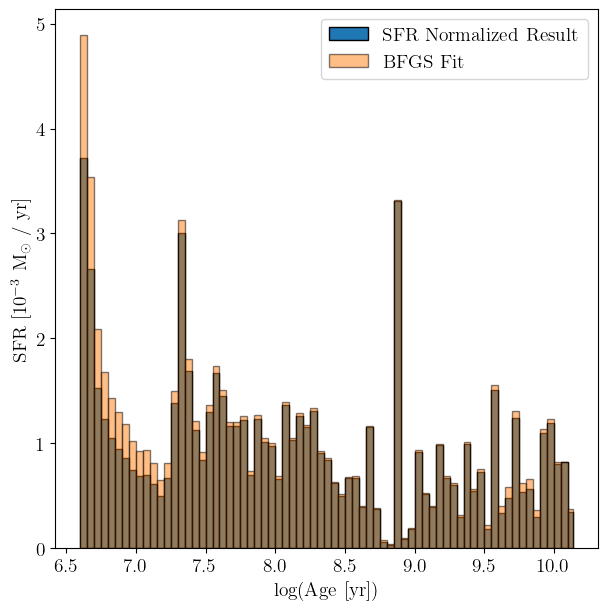

PyObject <matplotlib.legend.Legend object at 0x7f33560a71c0>

In [66]:
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="SFR Normalized Result")
    # yerr = sfr_norm_arr_err .* 1e3, 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
    # yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
    #         (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit", alpha=0.7)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

You can see that the histograms labelled "BFGS Fit", for which the templates were normalized to uniform stellar mass, favor more star formation prior to `logAge ~ 7`. There is less star formation in this period in the histograms labelled "SFR Normalized Result", where we have normalized the templates to uniform star formation rate. This difference is small enough that it is not easily noticable in plots of cumulative SFH, but significant enough that you should be normalizing your templates to uniform star formation rate for publication-quality results.

In [67]:
# Generate sample from the inverse Hessian matrix
# sfr_hessian_dist = Distributions.MvNormal(Optim.minimizer(sfr_result.map.result),
#                         LinearAlgebra.Hermitian(sfr_result.map.invH))
# sfr_hessian_sample = exp.(rand(sfr_hessian_dist, 10000)) .* sfr_norm
sfr_hessian_sample = rand(sfr_result.map, 10000) .* sfr_norm
hessian_sfr_norm = Matrix{Float64}(undef,length(unique_free_template_logAge),size(sfr_hessian_sample,2))
for i in eachindex(unique_free_template_logAge)
    idxs = findall(==(unique_free_template_logAge[i]), free_template_logAge)
    hessian_sfr_norm[i,:] .= vec(sum( @view sfr_hessian_sample[idxs,:]; dims=1))
end

# Now calculate quantiles
# hessian_cum_lower = quantile.(eachrow(hessian_cum_sfr), 0.16)
# hessian_cum_med = median.(eachrow(hessian_cum_sfr))
# hessian_cum_upper = quantile.(eachrow(hessian_cum_sfr), 0.84)
hessian_sfr_norm_lower = quantile.(eachrow(hessian_sfr_norm), 0.16)
hessian_sfr_norm_med = median.(eachrow(hessian_sfr_norm))
hessian_sfr_norm_upper = quantile.(eachrow(hessian_sfr_norm), 0.84)

71-element Vector{Float64}:
 0.007513214189632871
 0.005709091718030374
 0.003602538909456129
 0.002940797136174937
 0.0024932273588751156
 0.002258262032603093
 0.002066511803987461
 0.0018206369885156405
 0.0016876451186194218
 0.001632048761113172
 0.0014492451787778604
 0.0011713221456119702
 0.0016827373576727526
 ⋮
 0.0017120049692441386
 0.0005731604146094
 0.0008918859744362622
 0.0016190310691892287
 0.0009071432440309088
 0.000892011979083692
 0.0005509320439187256
 0.0012512140071523994
 0.001309565320847617
 0.0008805166168047703
 0.0008756582489949939
 0.0004579215174733668

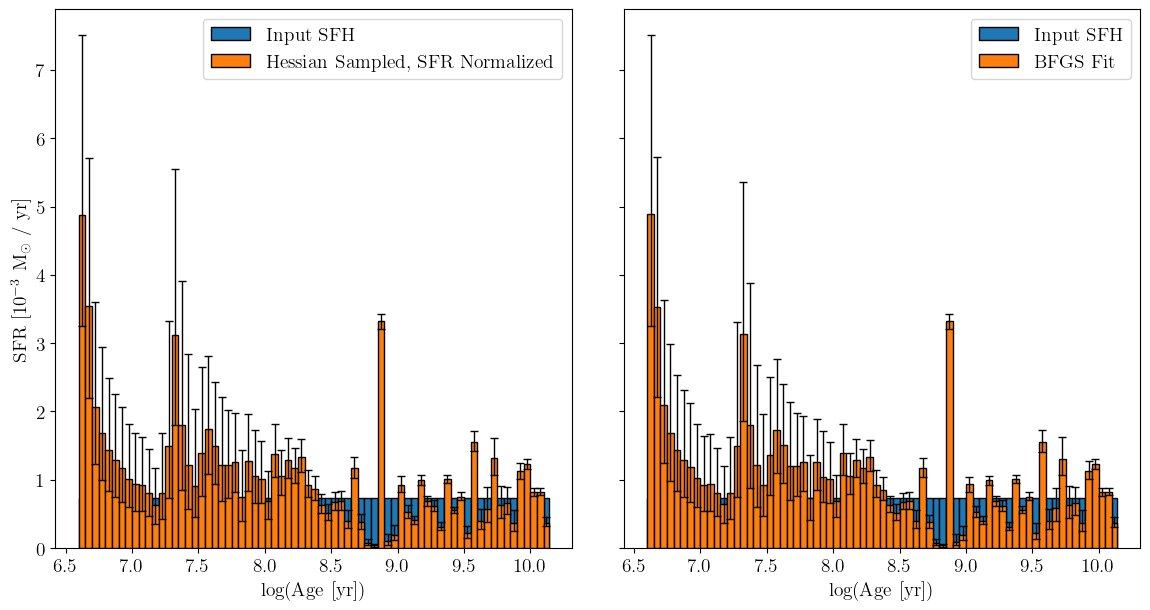

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [68]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_norm_med .- hessian_sfr_norm_lower) .* 1e3, 
            (hessian_sfr_norm_upper .- hessian_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Hessian Sampled, SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
            (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

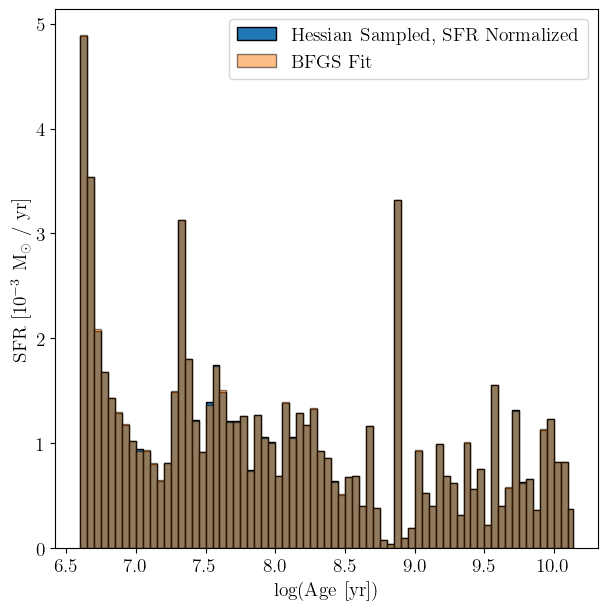

PyObject <matplotlib.legend.Legend object at 0x7f33559e8370>

In [69]:
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Hessian Sampled, SFR Normalized")
    # yerr = sfr_norm_arr_err .* 1e3, 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized Result")

ax1.bar(unique_free_template_logAge, hessian_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="BFGS Fit", alpha=0.5) 
    # yerr = [(hessian_sfr_med .- hessian_sfr_lower) .* 1e3, 
    #         (hessian_sfr_upper .- hessian_sfr_med) .* 1e3], 
    # capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="BFGS Fit", alpha=0.7)
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

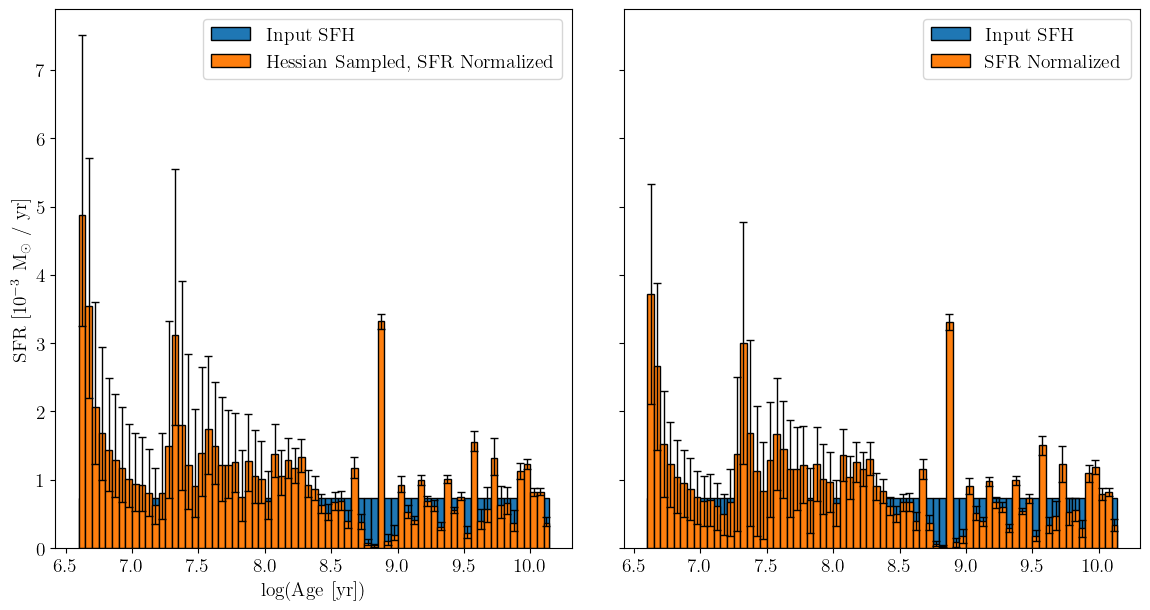

PyObject <matplotlib.legend.Legend object at 0x7f33557b5060>

In [70]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_free_template_logAge, hessian_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(hessian_sfr_norm_med .- hessian_sfr_norm_lower) .* 1e3, 
            (hessian_sfr_norm_upper .- hessian_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Hessian Sampled, SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_free_template_logAge, sfr_norm_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = sfr_norm_arr_err .* 1e3, 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized")
axs[2].legend()

## SFH Fitting: Constrained Metallicity Evolution

We will now use `fit_templates_mdf` to fit a constrained metallicity evolution model using the full template grid. This is the same approach we used to construct the model Hess diagram in the first place, so we expect to able to reproduce the true SFH fairly well. 

Note that in real data, the parameter σ (which sets the width of the metallicity distribution function at fixed age) can be difficult to constrain. As such, it is often preferable to fix σ rather than fitting it. This approach is supported by `fit_templates_mdf`. For the purposes of this example, we will allow σ to be fit to show it can be recovered robustly in the case of synthetic data.

In [71]:
import StarFormationHistories: fit_templates_mdf
mdf_α, mdf_β, mdf_σ = -0.15, -0.2, 0.2 # initial guess for the metallicity evolution parameters
mdf_result = fit_templates_mdf(templates,
                               data,
                               template_logAge, template_MH;
                               x0=vcat(construct_x0_mdf(template_logAge, max_logAge; normalize_value=1e4),
                                       [mdf_α,mdf_β,mdf_σ]))

(map = StarFormationHistories.LogTransformMDFResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([3.003541741148184, 1.2413023784123103, 0.9928573670090795, 0.8896688288872399, 0.959448079942893, 0.93512722648102, 1.036312037939783, 1.6635484016780977, 2.4551391397010724, 2.301734156111113  …  676.446450718247, 329.95437830791946, 1099.4411401438474, 580.9444414827518, 906.2825673676981, 1018.3648729550233, 814.6256985071549, -0.10004487748470088, -0.49797717854652

We will now calculate the per-template coefficients using `calculate_coeffs_mdf`, which we can then use like the outfits of `fit_templates` for other methods like `calculate_cum_sfr`.

In [72]:
mdf_coeffs = calculate_coeffs_mdf(mdf_result.map.μ, template_logAge, template_MH)
mdf_coeffs *= template_norm
            
_, mdf_cum_sfr_arr, mdf_sfr_arr, mdf_mean_mh_arr =
    calculate_cum_sfr(mdf_coeffs, template_logAge, max_logAge, template_MH)

([6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05  …  9.65001, 9.70001, 9.75001, 9.80001, 9.85001, 9.90001, 9.95001, 10.00001, 10.05001, 10.10001], [0.9999999999999998, 0.9997000818163866, 0.9995761317645034, 0.9994769901497821, 0.9993881524101489, 0.9992923468744822, 0.999198969893776, 0.9990954891197893, 0.9989293757583038, 0.9986842182293741  …  0.6823707500615708, 0.6221396069878439, 0.5919994945216166, 0.5418183146795567, 0.4742718617597626, 0.44132431970910757, 0.3315397992463884, 0.273529684293512, 0.18303298244263622, 0.08134431976550782], [0.006183126797682504, 0.0022774668715518104, 0.001623533833357674, 0.0012965905601855904, 0.0012462235643948133, 0.0010825430660959545, 0.0010692149532413855, 0.0015297128757984367, 0.0020121047703368384, 0.0016812397253384258  …  0.001106665728496927, 0.0004935603050779139, 0.0007323795743110875, 0.0008786135632653449, 0.0003819604324904431, 0.0011343222858970871, 0.0005341940931969795, 0.0007427251106114481, 0.0007438200681402471, 0.

### Sampling from Inverse Hessian 

We'll now draw samples from the posterior using the same approximation techinque as we did in the previous section.

In [73]:
# # This is effectively what rand(mdf_result.map, 10000) is doing.
# mdf_dist = MvNormal(Optim.minimizer(mdf_result.map.result),
#                     Hermitian(Optim.trace(mdf_result.map.result)[end].metadata["~inv(H)"]))
# mdf_sample = rand(mdf_dist, 10000)

# # Transform the variables, noting that the stellar mass coefficients `mdf_sample[begin:end-3,:]` 
# # and σ `mdf_sample[end,:]` are fit with logarithmic transformations so we have to transform them back.
# # α and β are optimized directly, without a transformation.
# @views mdf_sample[begin:end-3,:] .= exp.(mdf_sample[begin:end-3,:]) .* template_norm
# @views mdf_sample[end,:] .= exp.(mdf_sample[end,:])

In [74]:
mdf_sample = rand(mdf_result.map, 10000)
@views mdf_sample[begin:end-3,:] *= template_norm # Correct the stellar mass coefficients for the template normalization
# Calculate the cumulative SFH for each point in the sample
# and find the 1-σ range
mdf_cum_sfr = Vector{Vector{Float64}}(undef,0)
mdf_sfr = Vector{Vector{Float64}}(undef,0)
mdf_mh = Vector{Vector{Float64}}(undef,0)
for x in eachcol(mdf_sample)
    tmp_coeffs = calculate_coeffs_mdf(x, template_logAge, template_MH)
    _, mdf_1, mdf_2, mdf_3 = calculate_cum_sfr(tmp_coeffs, template_logAge, max_logAge, template_MH)
    push!(mdf_cum_sfr, mdf_1)
    push!(mdf_sfr, mdf_2)
    push!(mdf_mh, mdf_3)
end
mdf_cum_sfr = reduce(hcat, mdf_cum_sfr) 
mdf_sfr = reduce(hcat, mdf_sfr) 
mdf_mh = reduce(hcat, mdf_mh) 

# Now calculate quantiles
mdf_cum_lower = quantile.(eachrow(mdf_cum_sfr), 0.16)
mdf_cum_med = median.(eachrow(mdf_cum_sfr))
mdf_cum_upper = quantile.(eachrow(mdf_cum_sfr), 0.84)
mdf_sfr_lower = quantile.(eachrow(mdf_sfr), 0.16)
mdf_sfr_med = median.(eachrow(mdf_sfr))
mdf_sfr_upper = quantile.(eachrow(mdf_sfr), 0.84)
mdf_mh_lower = quantile.(eachrow(mdf_mh), 0.16)
mdf_mh_med = median.(eachrow(mdf_mh))
mdf_mh_upper = quantile.(eachrow(mdf_mh), 0.84);

We can look at the marginal distribution of the metallicity variables

In [75]:
println((α, β, σ))
mdf_sample[end-2:end,:]

(-0.1, -0.5, 0.1)


3×10000 Matrix{Float64}:
 -0.100347  -0.100167  -0.0999955  …  -0.0988284  -0.0999877  -0.0999273
 -0.497227  -0.49911   -0.498222      -0.500445   -0.499321   -0.497604
  0.105321   0.105562   0.106077       0.10403     0.10476     0.104131

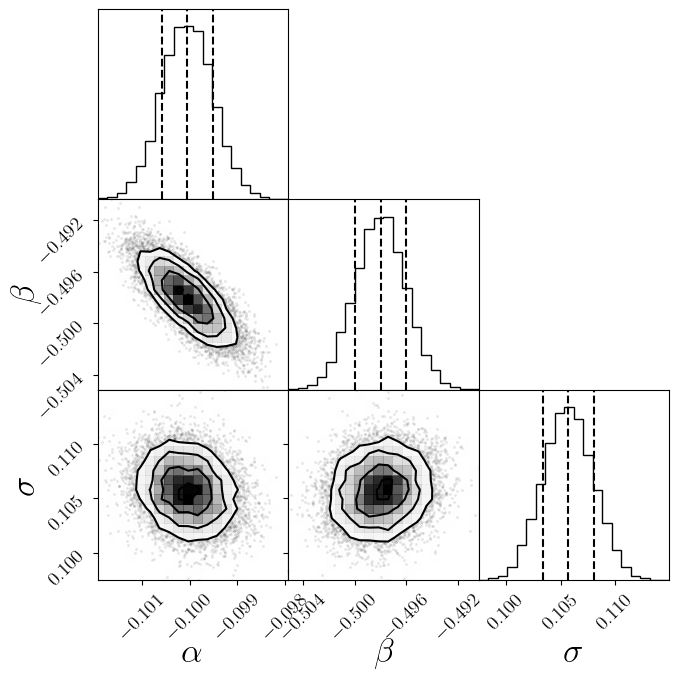

In [76]:
@pyimport corner # Easy marginal distributions
fig=plt.figure(figsize=(7,7))
# fig.suptitle("Linear M/H")
corner.corner( permutedims(@view mdf_sample[end-2:end,:]),
                fig=fig,
                labels=[L"\alpha", L"\beta", L"\sigma"],
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=4,
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

We see that the inverse Hessian has captured some covariance between the parameters. Now we'll plot the cumulative SFH and metallicity evolution.

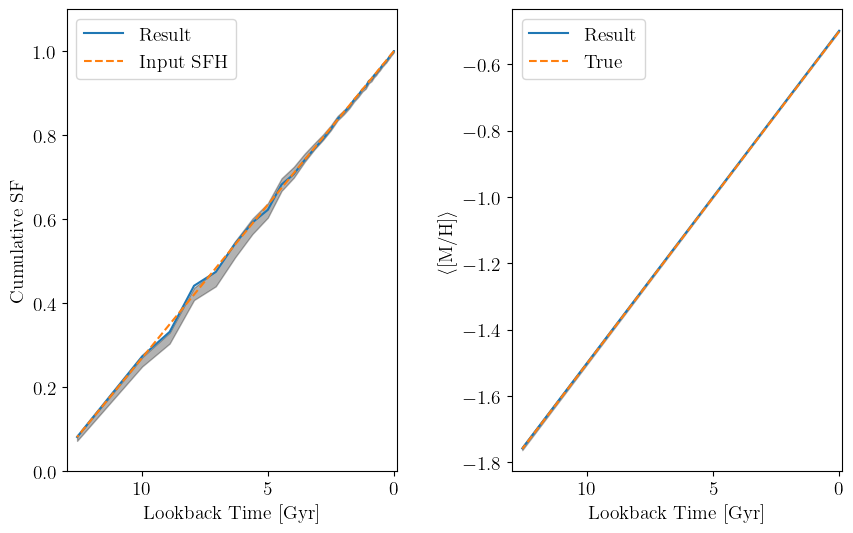

PyObject <matplotlib.legend.Legend object at 0x7f31d73d97b0>

In [77]:
# Now plot cumulative SFH and MH evolution for the metallicity evolution model
fig,axs=plt.subplots(nrows=1,ncols=2,sharex=true,sharey=false,figsize=(10,6))
fig.subplots_adjust(hspace=0.0,wspace=0.35)

axs[1].plot( exp10.(unique_template_logAge)./1e9, mdf_cum_sfr_arr, label="Result" ) # This is MAP result
# axs[1].plot( exp10.(unique_template_logAge)./1e9, mdf_cum_med, label="Result" ) # This is median of samples
axs[1].plot( exp10.(unique_template_logAge)./1e9, cum_sfr_arr, label="Input SFH", ls="--" )
axs[1].fill_between( exp10.(unique_template_logAge)./1e9, mdf_cum_lower, mdf_cum_upper, alpha=0.3, fc="k")

axs[1].set_xlim([13.0,-0.1])
axs[1].set_ylim([0.0,1.1])
axs[1].set_xlabel("Lookback Time [Gyr]")
axs[1].set_ylabel("Cumulative SF")
axs[1].legend()

axs[2].plot( exp10.(unique_template_logAge)./1e9, mdf_mh_med, label="Result" )
axs[2].fill_between( exp10.(unique_template_logAge)./1e9, mdf_mh_lower, mdf_mh_upper, alpha=0.3, fc="k")
axs[2].plot( exp10.(unique_template_logAge)./1e9, mean_mh_arr, label="True", ls="--" )

axs[2].set_xlabel("Lookback Time [Gyr]")
axs[2].set_ylabel(L"$\langle$[M/H]$\rangle$")
axs[2].legend()

The above plots show that we are able to measure the cumulative SFH and age-metallicity relation simultaneously and that they are statistically consistent with the input model.

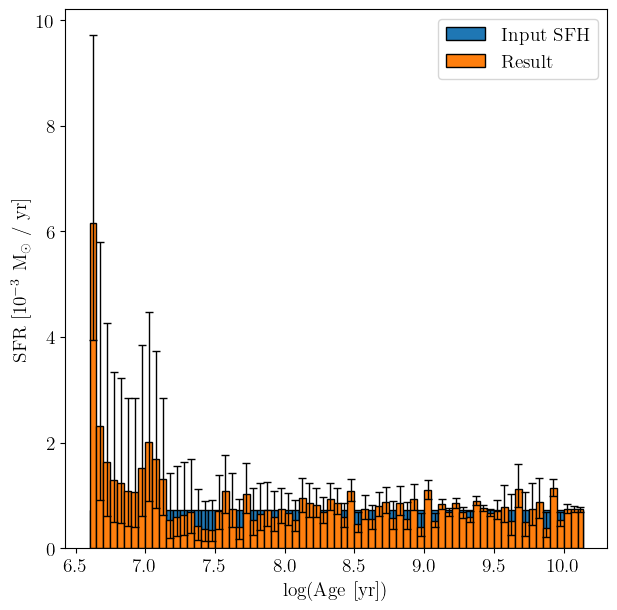

PyObject <matplotlib.legend.Legend object at 0x7f31d7254160>

In [78]:
# Now plot the SFRs for the metallicity evolution model
fig,ax1 = plt.subplots(figsize=(7,7))
ax1.bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
ax1.bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# ax1.bar(unique_template_logAge, mdf_sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Result")
ax1.set_xlabel("log(Age [yr])")
ax1.set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
ax1.set_ylim([0.0, ax1.get_ylim()[2]])
ax1.legend()

We can also look at the overall mass-weighted metallicity distribution function that results from the combination of our star formation history and our age-metallicity relation.

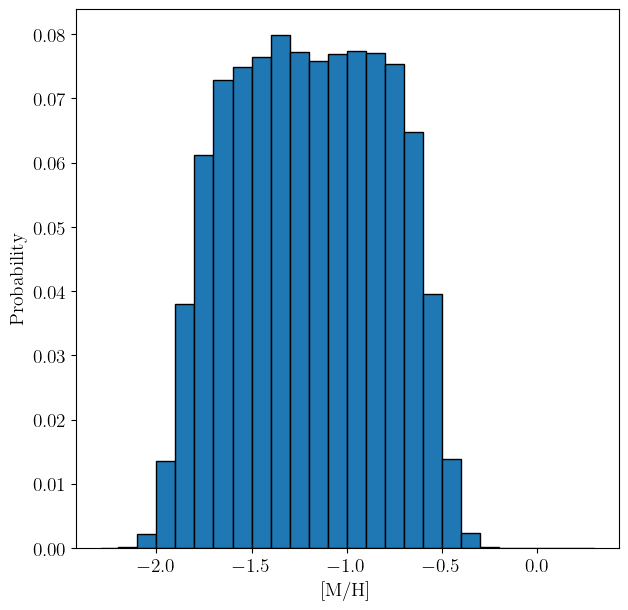

PyObject Text(27.219312263257578, 0.5, 'Probability')

In [79]:
# Make integrated MDF plot
import StarFormationHistories: mdf_amr
MDF_x, MDF = mdf_amr(mdf_coeffs, template_logAge, template_MH)
fig, ax1 = plt.subplots(figsize=(7,7))
ax1.bar(MDF_x, MDF, -abs(MDF_x[2] - MDF_x[3]), align="edge", linewidth=1, edgecolor="k")
ax1.set_xlabel("[M/H]")
ax1.set_ylabel("Probability")

The resulting fit is very consistent with the true values. We do, however, see that there is a slight bias for higher SFRs at recent times. This is a result of 
1. normalizing the templates to uniform stellar mass instead of uniform star formation rate, and
2. our isochrone grid being uniformly spaced in `log(age [yr])` and not simply `age`.

### Normalizing Templates to SFR

When we perform the maximum a posteriori optimization, we assume uniform priors on the multiplicative coefficients (these are the `R_j` in the documentation section "Constrained Metallicity Evolution"). We sampled each template with equal stellar mass, but they do not have all have equal width in the time domain as our isochrone grid is uniformly spaced in `log(age [yr])` and not simply `age`. As a result, the templates all have the same stellar mass, but they do not all have the same star formation rate due to this non-uniform time binning. As such our uniform priors on the coefficients `R_j` are *not* uniform in star formation rate. This results in a slight bias towards higher star formation rates at earlier times. 

In [80]:
# Compute change in time [yr] between bins of logAge
template_δt = diff(vcat(exp10.(unique_template_logAge), exp10(max_logAge)))
sfr_norm = 1e-3 # Star formation rate in solar masses / yr to normalize templates to
# Now normalize the templates:
# SFR = stellar mass / dt; sfr_norm = A * template_norm / dt; where A is a multiplicative constant
# since we originally normalized all the templates to contain stellar mass = `template_norm`
# Solve for A = sfr_norm * dt / template_norm
sfr_templates = deepcopy(templates)
for i in eachindex(sfr_templates)
    idx = findfirst(==(template_logAge[i]), unique_template_logAge)
    A = sfr_norm * template_δt[idx] / template_norm
    sfr_templates[i] .*= A
end 

In [81]:
# And now fit
mdf_sfr_result = fit_templates_mdf(sfr_templates, data, template_logAge, template_MH;
                                   x0=vcat(fill(1e-2,length(unique_template_logAge)),
                                           [mdf_α,mdf_β,mdf_σ]))

(map = StarFormationHistories.LogTransformMDFResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([6.1831267976857385, 2.2774668715488455, 1.623533833354945, 1.2965905601849363, 1.2462235643955233, 1.082543066096004, 1.069214953241512, 1.5297128758020067, 2.012104770335668, 1.681239725339287  …  0.8786135632655926, 0.38196043249043915, 1.1343222858968194, 0.5341940931972007, 0.7427251106112759, 0.7438200681403433, 0.733595656369908, -0.10004487748470024, -0.49797717

In [82]:
# # This is effectively what rand(mdf_sfr_result.map, 10000) is doing.
# # Generate sample from the inverse Hessian matrix
# mdf_sfr_dist = MvNormal(Optim.minimizer(mdf_sfr_result.map.result),
#                         Hermitian(Optim.trace(mdf_sfr_result.map.result)[end].metadata["~inv(H)"]))
# mdf_sfr_sample = rand(mdf_sfr_dist, 10000)

# # Transform the variables, noting that the SFR coefficients `mdf_sfr_sample[begin:end-3,:]` 
# # and σ `mdf_sfr_sample[end,:]` are fit with logarithmic transformations so we have to transform them back.
# # α and β are optimized directly, without a transformation.
# @views mdf_sfr_sample[begin:end-3,:] .= exp.(mdf_sfr_sample[begin:end-3,:]) .* sfr_norm
# @views mdf_sfr_sample[end,:] .= exp.(mdf_sfr_sample[end,:]);

In [83]:
mdf_sfr_sample = rand(mdf_sfr_result.map, 10000)
@views mdf_sfr_sample[begin:end-3,:] *= sfr_norm # Correct the SFR coefficients for the template normalization

71×10000 Matrix{Float64}:
 0.00411273   0.00325492   0.00558958   …  0.00599098   0.00748165
 0.00438703   0.00680311   0.00345553      0.000789388  0.00158165
 0.00762401   0.000584745  0.00401694      0.00472016   0.000787933
 0.00205453   0.00341869   0.000712517     0.00295818   0.00422552
 0.000126934  0.00103996   0.00323319      0.00286305   0.000832587
 0.00610028   0.000898114  0.000515475  …  0.00215106   0.0076505
 0.00199648   0.00120364   0.000200613     0.00109771   0.000239281
 0.00109557   0.00151      0.000834911     0.000743357  0.000913141
 0.000648291  0.00175648   0.00264149      0.00059766   0.00166712
 0.00197776   0.00415093   0.00116615      0.0022494    0.0015088
 0.0010196    0.000732224  0.000612466  …  0.00416375   0.00132834
 0.00108578   0.00135419   0.000328291     7.06222e-5   0.000846677
 0.0018253    0.000144832  0.000703073     9.12918e-5   0.000670144
 ⋮                                      ⋱               
 0.00090751   0.00144651   0.000810182    

In [84]:
# Now calculate quantiles
mdf_sfr_norm_lower = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.16)
mdf_sfr_norm_med = median.(eachrow(@view mdf_sfr_sample[begin:end-3,:]))
mdf_sfr_norm_upper = quantile.(eachrow(@view mdf_sfr_sample[begin:end-3,:]), 0.84);

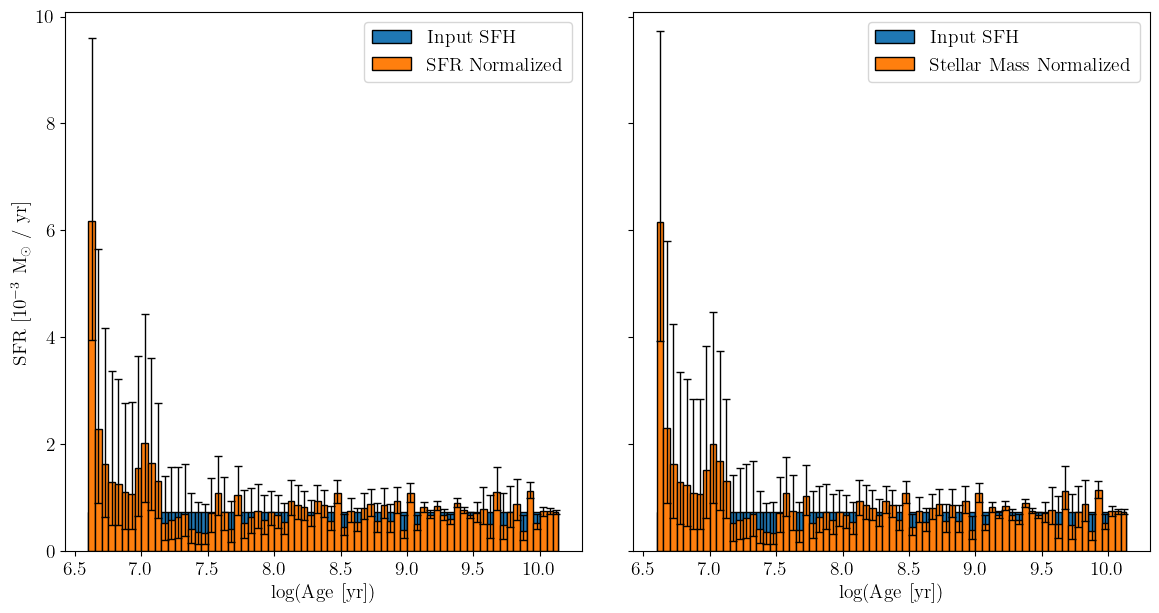

PyObject Text(0.5, 29.371800193718016, 'log(Age [yr])')

In [85]:
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=true,sharey=true,figsize=(14,7))
fig.subplots_adjust(hspace=0.0,wspace=0.1)

axs[1].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[1].bar(unique_template_logAge, mdf_sfr_norm_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.map.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
# axs[1].bar(unique_template_logAge, mdf_sfr_result.mle.μ[begin:end-3] .* 1e3 .* sfr_norm; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_norm_med .- mdf_sfr_norm_lower) .* 1e3, 
        (mdf_sfr_norm_upper .- mdf_sfr_norm_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="SFR Normalized")

axs[1].set_xlabel("log(Age [yr])")
axs[1].set_ylabel(L"SFR [$10^{-3}$ M$_\odot$ / yr]")
axs[1].set_ylim([0.0, axs[1].get_ylim()[2]])
axs[1].legend()

axs[2].bar(unique_template_logAge, sfr_arr .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", label="Input SFH")
axs[2].bar(unique_template_logAge, mdf_sfr_med .* 1e3; width=diff(vcat(unique_template_logAge,max_logAge)), align="edge", 
    yerr = [(mdf_sfr_med .- mdf_sfr_lower) .* 1e3, 
            (mdf_sfr_upper .- mdf_sfr_med) .* 1e3], 
    capsize=3, error_kw=Dict("elinewidth"=>1,"capthick"=>1), label="Stellar Mass Normalized")
axs[2].legend()
axs[2].set_xlabel("log(Age [yr])")

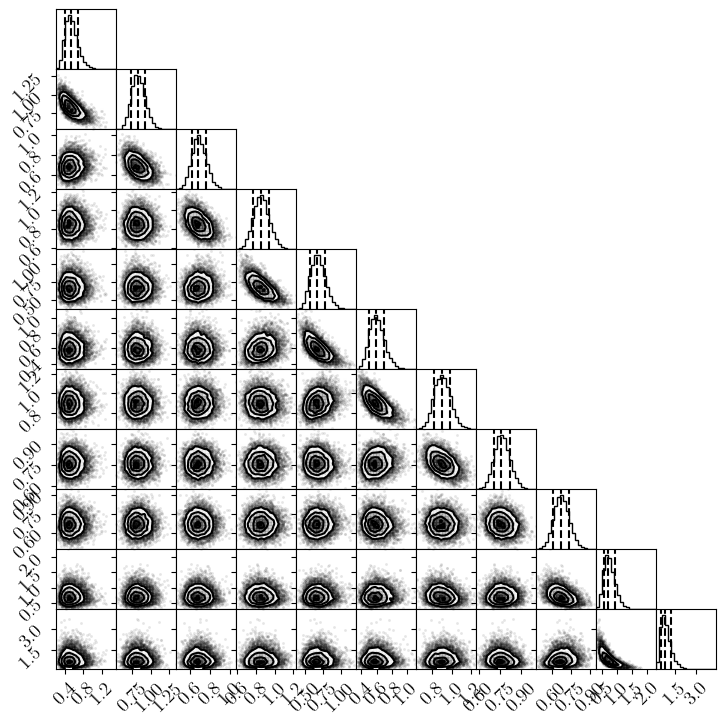

In [86]:
fig=plt.figure(figsize=(7,7))
# corner.corner( permutedims(@view mdf_sfr_sample[end-6:end-3,:]) .* 1e3,
# corner.corner( log.(permutedims(@view mdf_sfr_sample[end-6:end-3,:])) .+ log(1e3),
corner.corner( permutedims(@view mdf_sfr_sample[50:60,:]) .* 1e3,
                # range=[0.1 for i in 1:3],
                #range=[(0,3) for i in 1:3],
                fig=fig,
                # labels=[L"\alpha", L"\beta", L"\sigma"],
                quantiles=[0.16,0.5,0.84],
                max_n_ticks=4,
                show_titles=false,
                title_kwargs=Dict("fontsize"=>17),
                label_kwargs=Dict("fontsize"=>25))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

I actually think the overabundance at recent times is due to the way that I am setting the coefficients; I am assuming that the first bin actually spans from present-day to logage of 6.6, which results in much higher stellar mass in that template than perhaps there should be ... I think that may be the problem actually. Should probably require logage to be `length(templates)+1` corresponding to, like, the left-bin edges or something like that.

Fixed that and the issue still hasn't gone away. Something wrong with the prior then? Or maybe it's just a peculiarity with the isochrone / template grid? Try restricting to only logAge > 7 and see what happens. Problem still occurs when cutting out the most recent isochrones.

In [87]:
# Try to solve for data without random error
ttt=similar(first(free_templates))
ccc = rand(length(free_templates)) .* 10
composite!(ttt,ccc,free_templates)
ttt

99×99 Matrix{Float64}:
 0.0          0.0          0.0         …  0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0         …  0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          0.0          0.0            0.0          0.0
 0.0          1.75155e-11  9.30779e-9     0.0          0.0
 3.13369e-7   1.03534e-6   2.17914e-6     0.0          0.0
 9.7396e-6    3.19174e-5   6.65064e-5  …  0.0          0.0
 0.000154858  0.000503929  0.00104446     0.0          0.0
 0.00127693   0.00412496   0.00850841     0.0          0.0
 ⋮                                     ⋱               
 0.0562112    0.0561561    0.0573504      0.000102702  0.000104316
 0.0513119    0.0542634    0.0580868      8.24176e-5   7.08399e-5
 0.0512317    0.05716

In [88]:
tmpttt=fit_templates(free_templates, ttt; x0=ones(length(free_templates)).*5)

(map = StarFormationHistories.LogTransformFTResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Optim.MultivariateOptimizationResults{Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}, Vector{Float64}, Float64, Float64, Vector{Optim.OptimizationState{Float64, Optim.BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Optim.Flat}}}, Bool, @NamedTuple{f_limit_reached::Bool, g_limit_reached::Bool, h_limit_reached::Bool, time_limit::Bool, callback::Bool, f_increased::Bool}}}([4.455494729099938, 2.506295390152942, 2.0097904081830635, 2.0988784167437498, 6.299822154619831, 4.24212735504403, 2.9734024189044685, 1.9705090014644562, 3.8983669391550513, 4.8459804333925165  …  6.858481954945231, 7.243348907792503, 4.9557043528815345, 4.951290878836725, 4.364607649565793, 5.735240234922618, 6.41645100439966, 6.229545339299734, 6.034022949656774, 6.1

In [89]:
isapprox(tmpttt.mle.μ, ccc; rtol=1e-3)

true

In [90]:
construct_x0_mdf(template_logAge, max_logAge; normalize_value=1)

71-element Vector{Float64}:
 3.546754852763302e-5
 3.979524397685404e-5
 4.465099813547928e-5
 5.009924391101028e-5
 5.621227621472872e-5
 6.307121127124622e-5
 7.07670629815149e-5
 7.940195062200915e-5
 8.909045390546745e-5
 9.99611333840729e-5
 0.0001121582363698718
 0.00012584361100895583
 0.00014119885390804593
 ⋮
 0.03161121376527193
 0.03546836520752058
 0.039796160306759906
 0.044652026274542234
 0.05010039750201435
 0.05621357056512201
 0.06307266355627485
 0.0707686924721193
 0.07940377894053545
 0.0890925053125976
 0.09996343510072664
 0.0810787431184313

In [91]:
unique_logAge

71-element Vector{Float64}:
  6.6
  6.65
  6.7
  6.75
  6.8
  6.85
  6.9
  6.95
  7.0
  7.05
  7.1
  7.15
  7.2
  ⋮
  9.55001
  9.60001
  9.65001
  9.70001
  9.75001
  9.80001
  9.85001
  9.90001
  9.95001
 10.00001
 10.05001
 10.10001